In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Dropout, concatenate

from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [5]:
dataset = pd.read_csv('../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [6]:
print(dataset.columns)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [7]:
# specify the number of lag hours
n_hours = 24*3
K = 24
S = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [8]:
# Pre-processing
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96337, 384)


In [9]:
stages_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),var1(t-70),var2(t-70),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04


#### Prior unknown covariates (6)

In [10]:
prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
print("prior_unknown.shape:", prior_unknown.shape)

prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, S)
print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

prior_unknown.shape: (96432, 6)
prior_unknown_supervised.shape: (96337, 576)


In [11]:
prior_unknown_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),...,var3(t+22),var4(t+22),var5(t+22),var6(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.88,0.00,2.72,0.0,2.10,0.0,2.89,0.00,2.73
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.89,0.00,2.73,0.0,2.12,0.0,2.87,0.00,2.74
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,0.0,2.15,0.00,2.83,...,0.0,2.87,0.00,2.74,0.0,2.14,0.0,2.89,0.00,2.74
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,0.0,2.13,0.00,2.84,...,0.0,2.89,0.00,2.74,0.0,2.15,0.0,2.87,0.00,2.74
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,0.0,2.12,0.00,2.84,...,0.0,2.87,0.00,2.74,0.0,2.15,0.0,2.89,0.00,2.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,0.0,1.93,325.17,2.51,...,0.0,2.83,534.14,2.47,0.0,1.92,0.0,2.86,456.34,2.49
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,0.0,1.94,406.56,2.48,...,0.0,2.86,456.34,2.49,0.0,1.92,0.0,2.88,380.19,2.48
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.0,1.94,445.67,2.43,...,0.0,2.88,380.19,2.48,0.0,1.93,0.0,2.89,287.12,2.54


#### Prior known covariates (9)

In [12]:
prior_known = dataset[['WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', 'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, S)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (96432, 9)
prior_known_supervised.shape: (96337, 864)


In [13]:
prior_known_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var1(t-71),...,var9(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23),var7(t+23),var8(t+23),var9(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.34,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.28,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,-0.28,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.73,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,-0.73,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.85,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,-0.85,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.49,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,-0.49,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.21,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.79,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,1.31,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
12/30/20 21:00,1.31,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,0.86,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
12/30/20 22:00,0.86,0.0,0.0,2.58,0.0,0.0,2.57,0.0,0.000000,0.42,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


### N_out, N_in, K

#### all past covariates in past $w$ hours

In [14]:
# 15 covariates in total
cov = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26',\
                   'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', \
                    'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]

cov_supervised = series_to_supervised(cov, n_hours, S)
print("cov_supervised.shape:", cov_supervised.shape)

cov_supervised.shape: (96337, 1440)


In [15]:
past_cov_supervised = cov_supervised.iloc[:, :n_hours*cov.shape[1]]

In [16]:
past_cov_supervised  # 6 + 9 = 15 features

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.76,2.13,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.78,2.03,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.77,1.47,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.77,0.83,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.77,0.31,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.57,1.57,0.0,0.0,2.56,0.0,0.0,2.57,0.0,0.0
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.55,1.94,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.56,2.08,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0


#### all target water stages in past $w$ hours

In [17]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [18]:
past_ws_supervised  # 4

,past_ws_supervised_var1(t-72),past_ws_supervised_var2(t-72),past_ws_supervised_var3(t-72),past_ws_supervised_var4(t-72),past_ws_supervised_var1(t-71),past_ws_supervised_var2(t-71),past_ws_supervised_var3(t-71),past_ws_supervised_var4(t-71),past_ws_supervised_var1(t-70),past_ws_supervised_var2(t-70),...,past_ws_supervised_var3(t-3),past_ws_supervised_var4(t-3),past_ws_supervised_var1(t-2),past_ws_supervised_var2(t-2),past_ws_supervised_var3(t-2),past_ws_supervised_var4(t-2),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.38,1.34,1.79,1.92,1.94,1.91,2.11,2.29,2.27,2.21
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.94,1.91,2.11,2.29,2.27,2.21,2.07,2.27,2.26,2.22
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.27,2.21,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.60,0.54,1.14,1.18,1.17,1.25,1.62,1.65,1.70,1.67
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,1.17,1.25,1.62,1.65,1.70,1.67,1.93,1.95,2.00,2.00
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.70,1.67,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25


#### merge all data (ws, covariates) in past $w$ hours

In [19]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*cov.shape[1]:(i+1)*cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [20]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :], 
                                    past_ws_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :]], 
                                   axis=1)

past_cov_ws_supervised = past_cov_ws_supervised[columns]

In [21]:
past_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.11,2.29,2.27,2.21
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.07,2.27,2.26,2.22
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,1.57,1.80,1.80,1.72
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.81,1.04,1.03,0.96
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.56,0.0,0.0,2.57,0.0,0.0,1.62,1.65,1.70,1.67
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,1.93,1.95,2.00,2.00
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.57,0.0,0.0,2.57,0.0,0.0,2.19,2.21,2.25,2.25
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,2.11,2.12,2.22,2.19


#### shift prior known covariates in future  $S$ steps to the past

In [22]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, S*prior_known.shape[1]:]
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var1(t-47),...,shift_prior_known_supervised_var9(t+22),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.60,0.0,0.0,0.00,0.0,0.0,2.61,0.0,0.0,-0.07,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,-0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.68,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,-0.68,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-1.02,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,-1.02,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.97,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,-0.97,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.50,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.91,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.67,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,1.67,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.16,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,1.16,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,0.68,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.68,0.0,0.0,2.57,0.0,0.0,2.56,0.0,0.0,0.24,...,0.0,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### merge all past data and shifted prior know future covariate

In [23]:
columns1 = []
for i in range(n_hours):
    columns1 = columns1 + past_cov_ws_supervised.columns[i*data.shape[1]:(i+1)*data.shape[1]].tolist()
    columns1 = columns1 + shift_prior_known_supervised.columns[i*prior_known.shape[1]:(i+1)*prior_known.shape[1]].tolist()
# columns

In [24]:
shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :], 
                                                 shift_prior_known_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :]],
                                                axis=1)

shift_prior_known_cov_ws_supervised = shift_prior_known_cov_ws_supervised[columns1]

In [25]:
# shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
#                                                      axis=1)

In [26]:
shift_prior_known_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,past_ws_supervised_var4(t-1),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.21,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.22,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,1.72,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.96,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.42,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,1.67,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.00,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.25,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.19,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### target water stage in future $k$ time steps

In [27]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var2(t),var3(t),var4(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var1(t+2),var2(t+2),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42,-0.29,-0.02,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.27,0.53,0.50,0.42,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,-0.49,-0.57,-0.64,-0.46,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25,2.11,2.12,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,2.19,2.21,2.25,2.25,2.11,2.12,2.22,2.19,1.65,1.69,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,2.11,2.12,2.22,2.19,1.65,1.69,1.76,1.72,1.24,1.24,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,1.65,1.69,1.76,1.72,1.24,1.24,1.37,1.32,0.76,0.73,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Concatenation

In [28]:
all_data = concat([shift_prior_known_cov_ws_supervised, 
                   future_ws_supervised.iloc[:shift_prior_known_cov_ws_supervised.shape[0], :]], 
                  axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96337, 2112)


In [29]:
all_data

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Train & Test set

In [30]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 77069


In [31]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

2016

### Normalization

In [32]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (77069, 2016) (77069, 96) (19268, 2016) (19268, 96)


In [33]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (77069, 72, 28) (77069, 96) (19268, 72, 28) (19268, 96)


### Model

In [39]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]))

# 4 cnn with skip connection
x1 = layers.Conv1D(filters=256, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)


x1_merge1 = concatenate([model_input, x1])
x1 = layers.Conv1D(filters=128, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge1)


x1_merge2 = concatenate([model_input, x1])
x1 = layers.Conv1D(filters=64, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge2)


x1_merge3 = concatenate([model_input, x1])
x1 = layers.Conv1D(filters=32, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge3)


# 4 rnn with skip connection
x2 = layers.SimpleRNN(128, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)


x2_merge1 = concatenate([model_input, x2])
x2 = layers.SimpleRNN(64, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge1)


x2_merge2 = concatenate([model_input, x2])
x2 = layers.SimpleRNN(32, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge2)


x2_merge3 = concatenate([model_input, x2])
x2 = layers.Conv1D(filters=16, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge3)



merge = concatenate([model_input, x1, x2])
merge = layers.Flatten()(merge)
# x = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(merge)
# x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(64, activation='relu')(x)
x = Dense(train_y.shape[1])(merge)

ws_pararcnn = Model(model_input, x)
ws_pararcnn.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 72, 28)]     0                                            
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 72, 256)      14592       input_4[0][0]                    
__________________________________________________________________________________________________
simple_rnn_9 (SimpleRNN)        (None, 72, 128)      20096       input_4[0][0]                    
__________________________________________________________________________________________________
concatenate_21 (Concatenate)    (None, 72, 284)      0           input_4[0][0]                    
                                                                 conv1d_15[0][0]            

Epoch 1/8000

Epoch 00001: val_mae improved from inf to 0.05150, saving model to saved_model/ws_pararcnn_sc1_4layer_24h.h5
151/151 - 19s - loss: 0.0768 - mae: 0.0605 - val_loss: 0.0478 - val_mae: 0.0515
Epoch 2/8000

Epoch 00002: val_mae improved from 0.05150 to 0.04012, saving model to saved_model/ws_pararcnn_sc1_4layer_24h.h5
151/151 - 19s - loss: 0.0333 - mae: 0.0297 - val_loss: 0.0259 - val_mae: 0.0401
Epoch 3/8000

Epoch 00003: val_mae improved from 0.04012 to 0.03378, saving model to saved_model/ws_pararcnn_sc1_4layer_24h.h5
151/151 - 19s - loss: 0.0197 - mae: 0.0226 - val_loss: 0.0169 - val_mae: 0.0338
Epoch 4/8000

Epoch 00004: val_mae improved from 0.03378 to 0.03135, saving model to saved_model/ws_pararcnn_sc1_4layer_24h.h5
151/151 - 19s - loss: 0.0134 - mae: 0.0191 - val_loss: 0.0123 - val_mae: 0.0313
Epoch 5/8000

Epoch 00005: val_mae improved from 0.03135 to 0.02876, saving model to saved_model/ws_pararcnn_sc1_4layer_24h.h5
151/151 - 19s - loss: 0.0098 - mae: 0.0170 - val_

Epoch 45/8000

Epoch 00045: val_mae did not improve from 0.01587
151/151 - 19s - loss: 2.8582e-04 - mae: 0.0087 - val_loss: 5.6917e-04 - val_mae: 0.0159
Epoch 46/8000

Epoch 00046: val_mae did not improve from 0.01587
151/151 - 19s - loss: 2.8269e-04 - mae: 0.0086 - val_loss: 5.8560e-04 - val_mae: 0.0161
Epoch 47/8000

Epoch 00047: val_mae did not improve from 0.01587
151/151 - 19s - loss: 2.7945e-04 - mae: 0.0085 - val_loss: 5.7944e-04 - val_mae: 0.0161
Epoch 48/8000

Epoch 00048: val_mae improved from 0.01587 to 0.01571, saving model to saved_model/ws_pararcnn_sc1_4layer_24h.h5
151/151 - 19s - loss: 2.8262e-04 - mae: 0.0086 - val_loss: 5.5426e-04 - val_mae: 0.0157
Epoch 49/8000

Epoch 00049: val_mae did not improve from 0.01571
151/151 - 19s - loss: 2.7985e-04 - mae: 0.0085 - val_loss: 5.5236e-04 - val_mae: 0.0158
Epoch 50/8000

Epoch 00050: val_mae did not improve from 0.01571
151/151 - 20s - loss: 2.7879e-04 - mae: 0.0085 - val_loss: 5.5056e-04 - val_mae: 0.0159
Epoch 51/8000

Epoc

Epoch 96/8000

Epoch 00096: val_mae did not improve from 0.01316
151/151 - 19s - loss: 2.4840e-04 - mae: 0.0079 - val_loss: 4.9205e-04 - val_mae: 0.0148
Epoch 97/8000

Epoch 00097: val_mae did not improve from 0.01316
151/151 - 19s - loss: 2.5268e-04 - mae: 0.0080 - val_loss: 4.5808e-04 - val_mae: 0.0140
Epoch 98/8000

Epoch 00098: val_mae did not improve from 0.01316
151/151 - 19s - loss: 2.4975e-04 - mae: 0.0079 - val_loss: 4.6744e-04 - val_mae: 0.0141
Epoch 99/8000

Epoch 00099: val_mae did not improve from 0.01316
151/151 - 19s - loss: 2.5090e-04 - mae: 0.0080 - val_loss: 5.1812e-04 - val_mae: 0.0151
Epoch 100/8000

Epoch 00100: val_mae did not improve from 0.01316
151/151 - 19s - loss: 2.4740e-04 - mae: 0.0078 - val_loss: 5.7932e-04 - val_mae: 0.0160
Epoch 101/8000

Epoch 00101: val_mae did not improve from 0.01316
151/151 - 19s - loss: 2.4999e-04 - mae: 0.0079 - val_loss: 4.3209e-04 - val_mae: 0.0137
Epoch 102/8000

Epoch 00102: val_mae did not improve from 0.01316
151/151 - 19s 

Epoch 149/8000

Epoch 00149: val_mae did not improve from 0.01311
151/151 - 19s - loss: 2.3839e-04 - mae: 0.0077 - val_loss: 4.5761e-04 - val_mae: 0.0143
Epoch 150/8000

Epoch 00150: val_mae did not improve from 0.01311
151/151 - 19s - loss: 2.3533e-04 - mae: 0.0076 - val_loss: 4.1308e-04 - val_mae: 0.0133
Epoch 151/8000

Epoch 00151: val_mae did not improve from 0.01311
151/151 - 19s - loss: 2.3951e-04 - mae: 0.0078 - val_loss: 4.6370e-04 - val_mae: 0.0142
Epoch 152/8000

Epoch 00152: val_mae did not improve from 0.01311
151/151 - 19s - loss: 2.3677e-04 - mae: 0.0077 - val_loss: 5.2487e-04 - val_mae: 0.0154
Epoch 153/8000

Epoch 00153: val_mae did not improve from 0.01311
151/151 - 19s - loss: 2.3222e-04 - mae: 0.0075 - val_loss: 5.1532e-04 - val_mae: 0.0151
Epoch 154/8000

Epoch 00154: val_mae did not improve from 0.01311
151/151 - 19s - loss: 2.3846e-04 - mae: 0.0078 - val_loss: 5.0403e-04 - val_mae: 0.0147
Epoch 155/8000

Epoch 00155: val_mae did not improve from 0.01311
151/151 - 

Epoch 202/8000

Epoch 00202: val_mae did not improve from 0.01242
151/151 - 19s - loss: 2.2941e-04 - mae: 0.0075 - val_loss: 4.1694e-04 - val_mae: 0.0133
Epoch 203/8000

Epoch 00203: val_mae did not improve from 0.01242
151/151 - 19s - loss: 2.2969e-04 - mae: 0.0075 - val_loss: 4.1949e-04 - val_mae: 0.0133
Epoch 204/8000

Epoch 00204: val_mae did not improve from 0.01242
151/151 - 19s - loss: 2.2926e-04 - mae: 0.0075 - val_loss: 4.6939e-04 - val_mae: 0.0147
Epoch 205/8000

Epoch 00205: val_mae did not improve from 0.01242
151/151 - 19s - loss: 2.2598e-04 - mae: 0.0074 - val_loss: 3.9244e-04 - val_mae: 0.0129
Epoch 206/8000

Epoch 00206: val_mae did not improve from 0.01242
151/151 - 19s - loss: 2.2978e-04 - mae: 0.0075 - val_loss: 4.4843e-04 - val_mae: 0.0141
Epoch 207/8000

Epoch 00207: val_mae did not improve from 0.01242
151/151 - 19s - loss: 2.2965e-04 - mae: 0.0075 - val_loss: 3.9962e-04 - val_mae: 0.0130
Epoch 208/8000

Epoch 00208: val_mae did not improve from 0.01242
151/151 - 

Epoch 255/8000

Epoch 00255: val_mae did not improve from 0.01226
151/151 - 19s - loss: 2.2404e-04 - mae: 0.0074 - val_loss: 4.3199e-04 - val_mae: 0.0138
Epoch 256/8000

Epoch 00256: val_mae did not improve from 0.01226
151/151 - 19s - loss: 2.2470e-04 - mae: 0.0074 - val_loss: 4.2601e-04 - val_mae: 0.0136
Epoch 257/8000

Epoch 00257: val_mae did not improve from 0.01226
151/151 - 19s - loss: 2.2110e-04 - mae: 0.0073 - val_loss: 4.4576e-04 - val_mae: 0.0142
Epoch 258/8000

Epoch 00258: val_mae did not improve from 0.01226
151/151 - 19s - loss: 2.2364e-04 - mae: 0.0074 - val_loss: 4.4977e-04 - val_mae: 0.0139
Epoch 259/8000

Epoch 00259: val_mae did not improve from 0.01226
151/151 - 19s - loss: 2.2083e-04 - mae: 0.0072 - val_loss: 3.7645e-04 - val_mae: 0.0126
Epoch 260/8000

Epoch 00260: val_mae did not improve from 0.01226
151/151 - 19s - loss: 2.2498e-04 - mae: 0.0074 - val_loss: 4.9196e-04 - val_mae: 0.0144
Epoch 261/8000

Epoch 00261: val_mae did not improve from 0.01226
151/151 - 

Epoch 308/8000

Epoch 00308: val_mae improved from 0.01182 to 0.01133, saving model to saved_model/ws_pararcnn_sc1_4layer_24h.h5
151/151 - 19s - loss: 2.2081e-04 - mae: 0.0073 - val_loss: 3.2246e-04 - val_mae: 0.0113
Epoch 309/8000

Epoch 00309: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.1987e-04 - mae: 0.0073 - val_loss: 4.5587e-04 - val_mae: 0.0139
Epoch 310/8000

Epoch 00310: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.1841e-04 - mae: 0.0072 - val_loss: 4.6054e-04 - val_mae: 0.0139
Epoch 311/8000

Epoch 00311: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.1533e-04 - mae: 0.0071 - val_loss: 4.0913e-04 - val_mae: 0.0132
Epoch 312/8000

Epoch 00312: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.1894e-04 - mae: 0.0073 - val_loss: 4.8301e-04 - val_mae: 0.0142
Epoch 313/8000

Epoch 00313: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.1690e-04 - mae: 0.0072 - val_loss: 4.1218e-04 - val_mae: 0.0134
Epoch 314/800

Epoch 361/8000

Epoch 00361: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.1276e-04 - mae: 0.0071 - val_loss: 4.8863e-04 - val_mae: 0.0145
Epoch 362/8000

Epoch 00362: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.1412e-04 - mae: 0.0071 - val_loss: 4.2864e-04 - val_mae: 0.0132
Epoch 363/8000

Epoch 00363: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.1679e-04 - mae: 0.0072 - val_loss: 3.9622e-04 - val_mae: 0.0128
Epoch 364/8000

Epoch 00364: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.1253e-04 - mae: 0.0070 - val_loss: 4.3867e-04 - val_mae: 0.0139
Epoch 365/8000

Epoch 00365: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.1411e-04 - mae: 0.0071 - val_loss: 3.9781e-04 - val_mae: 0.0129
Epoch 366/8000

Epoch 00366: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.1540e-04 - mae: 0.0072 - val_loss: 3.5785e-04 - val_mae: 0.0120
Epoch 367/8000

Epoch 00367: val_mae did not improve from 0.01133
151/151 - 

Epoch 415/8000

Epoch 00415: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.0981e-04 - mae: 0.0070 - val_loss: 4.0586e-04 - val_mae: 0.0131
Epoch 416/8000

Epoch 00416: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.1087e-04 - mae: 0.0070 - val_loss: 3.8436e-04 - val_mae: 0.0126
Epoch 417/8000

Epoch 00417: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.1148e-04 - mae: 0.0071 - val_loss: 4.1073e-04 - val_mae: 0.0129
Epoch 418/8000

Epoch 00418: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.1070e-04 - mae: 0.0070 - val_loss: 3.5818e-04 - val_mae: 0.0121
Epoch 419/8000

Epoch 00419: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.1315e-04 - mae: 0.0071 - val_loss: 4.9997e-04 - val_mae: 0.0145
Epoch 420/8000

Epoch 00420: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.1243e-04 - mae: 0.0071 - val_loss: 3.8104e-04 - val_mae: 0.0128
Epoch 421/8000

Epoch 00421: val_mae did not improve from 0.01133
151/151 - 

Epoch 469/8000

Epoch 00469: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.1038e-04 - mae: 0.0071 - val_loss: 4.1306e-04 - val_mae: 0.0135
Epoch 470/8000

Epoch 00470: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.0866e-04 - mae: 0.0070 - val_loss: 3.8963e-04 - val_mae: 0.0130
Epoch 471/8000

Epoch 00471: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.0911e-04 - mae: 0.0070 - val_loss: 4.5524e-04 - val_mae: 0.0143
Epoch 472/8000

Epoch 00472: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.0974e-04 - mae: 0.0071 - val_loss: 3.6125e-04 - val_mae: 0.0121
Epoch 473/8000

Epoch 00473: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.0838e-04 - mae: 0.0070 - val_loss: 4.7617e-04 - val_mae: 0.0146
Epoch 474/8000

Epoch 00474: val_mae did not improve from 0.01133
151/151 - 19s - loss: 2.0578e-04 - mae: 0.0069 - val_loss: 4.8942e-04 - val_mae: 0.0145
Epoch 475/8000

Epoch 00475: val_mae improved from 0.01133 to 0.01132, savin

Epoch 522/8000

Epoch 00522: val_mae did not improve from 0.01132
151/151 - 19s - loss: 2.0775e-04 - mae: 0.0070 - val_loss: 4.0719e-04 - val_mae: 0.0130
Epoch 523/8000

Epoch 00523: val_mae did not improve from 0.01132
151/151 - 19s - loss: 2.0575e-04 - mae: 0.0069 - val_loss: 3.2443e-04 - val_mae: 0.0113
Epoch 524/8000

Epoch 00524: val_mae did not improve from 0.01132
151/151 - 19s - loss: 2.0654e-04 - mae: 0.0070 - val_loss: 4.4086e-04 - val_mae: 0.0136
Epoch 525/8000

Epoch 00525: val_mae did not improve from 0.01132
151/151 - 19s - loss: 2.0806e-04 - mae: 0.0070 - val_loss: 3.9777e-04 - val_mae: 0.0131
Epoch 526/8000

Epoch 00526: val_mae did not improve from 0.01132
151/151 - 19s - loss: 2.0745e-04 - mae: 0.0070 - val_loss: 3.4272e-04 - val_mae: 0.0120
Epoch 527/8000

Epoch 00527: val_mae improved from 0.01132 to 0.01098, saving model to saved_model/ws_pararcnn_sc1_4layer_24h.h5
151/151 - 19s - loss: 2.0401e-04 - mae: 0.0069 - val_loss: 3.1099e-04 - val_mae: 0.0110
Epoch 528/800

Epoch 575/8000

Epoch 00575: val_mae did not improve from 0.01098
151/151 - 19s - loss: 2.0836e-04 - mae: 0.0071 - val_loss: 4.0336e-04 - val_mae: 0.0132
Epoch 576/8000

Epoch 00576: val_mae did not improve from 0.01098
151/151 - 19s - loss: 2.0148e-04 - mae: 0.0068 - val_loss: 3.6364e-04 - val_mae: 0.0123
Epoch 577/8000

Epoch 00577: val_mae did not improve from 0.01098
151/151 - 18s - loss: 2.0361e-04 - mae: 0.0069 - val_loss: 4.4253e-04 - val_mae: 0.0135
Epoch 578/8000

Epoch 00578: val_mae did not improve from 0.01098
151/151 - 19s - loss: 2.0410e-04 - mae: 0.0069 - val_loss: 4.2096e-04 - val_mae: 0.0133
Epoch 579/8000

Epoch 00579: val_mae did not improve from 0.01098
151/151 - 19s - loss: 2.0350e-04 - mae: 0.0069 - val_loss: 4.3199e-04 - val_mae: 0.0137
Epoch 580/8000

Epoch 00580: val_mae did not improve from 0.01098
151/151 - 19s - loss: 2.0165e-04 - mae: 0.0068 - val_loss: 3.5208e-04 - val_mae: 0.0125
Epoch 581/8000

Epoch 00581: val_mae did not improve from 0.01098
151/151 - 

Epoch 629/8000

Epoch 00629: val_mae did not improve from 0.01098
151/151 - 19s - loss: 2.0033e-04 - mae: 0.0068 - val_loss: 3.8495e-04 - val_mae: 0.0125
Epoch 630/8000

Epoch 00630: val_mae did not improve from 0.01098
151/151 - 20s - loss: 2.0423e-04 - mae: 0.0070 - val_loss: 4.1300e-04 - val_mae: 0.0130
Epoch 631/8000

Epoch 00631: val_mae did not improve from 0.01098
151/151 - 19s - loss: 2.0195e-04 - mae: 0.0068 - val_loss: 3.6136e-04 - val_mae: 0.0122
Epoch 632/8000

Epoch 00632: val_mae did not improve from 0.01098
151/151 - 19s - loss: 1.9687e-04 - mae: 0.0066 - val_loss: 3.6391e-04 - val_mae: 0.0123
Epoch 633/8000

Epoch 00633: val_mae did not improve from 0.01098
151/151 - 19s - loss: 2.0155e-04 - mae: 0.0068 - val_loss: 3.7454e-04 - val_mae: 0.0124
Epoch 634/8000

Epoch 00634: val_mae did not improve from 0.01098
151/151 - 19s - loss: 2.0246e-04 - mae: 0.0069 - val_loss: 4.2253e-04 - val_mae: 0.0136
Epoch 635/8000

Epoch 00635: val_mae did not improve from 0.01098
151/151 - 

Epoch 683/8000

Epoch 00683: val_mae did not improve from 0.01098
151/151 - 19s - loss: 1.9906e-04 - mae: 0.0067 - val_loss: 3.3824e-04 - val_mae: 0.0118
Epoch 684/8000

Epoch 00684: val_mae did not improve from 0.01098
151/151 - 19s - loss: 2.0049e-04 - mae: 0.0068 - val_loss: 3.5106e-04 - val_mae: 0.0122
Epoch 685/8000

Epoch 00685: val_mae did not improve from 0.01098
151/151 - 19s - loss: 1.9860e-04 - mae: 0.0067 - val_loss: 3.5343e-04 - val_mae: 0.0118
Epoch 686/8000

Epoch 00686: val_mae did not improve from 0.01098
151/151 - 19s - loss: 1.9972e-04 - mae: 0.0068 - val_loss: 3.5235e-04 - val_mae: 0.0120
Epoch 687/8000

Epoch 00687: val_mae did not improve from 0.01098
151/151 - 19s - loss: 2.0090e-04 - mae: 0.0068 - val_loss: 3.5256e-04 - val_mae: 0.0119
Epoch 688/8000

Epoch 00688: val_mae did not improve from 0.01098
151/151 - 19s - loss: 1.9822e-04 - mae: 0.0067 - val_loss: 3.8176e-04 - val_mae: 0.0125
Epoch 689/8000

Epoch 00689: val_mae did not improve from 0.01098
151/151 - 

Epoch 737/8000

Epoch 00737: val_mae did not improve from 0.01098
151/151 - 19s - loss: 2.0034e-04 - mae: 0.0069 - val_loss: 3.9393e-04 - val_mae: 0.0131
Epoch 738/8000

Epoch 00738: val_mae did not improve from 0.01098
151/151 - 19s - loss: 1.9817e-04 - mae: 0.0067 - val_loss: 3.6779e-04 - val_mae: 0.0123
Epoch 739/8000

Epoch 00739: val_mae did not improve from 0.01098
151/151 - 19s - loss: 1.9768e-04 - mae: 0.0067 - val_loss: 4.6337e-04 - val_mae: 0.0139
Epoch 740/8000

Epoch 00740: val_mae did not improve from 0.01098
151/151 - 19s - loss: 1.9701e-04 - mae: 0.0067 - val_loss: 3.9928e-04 - val_mae: 0.0128
Epoch 741/8000

Epoch 00741: val_mae did not improve from 0.01098
151/151 - 19s - loss: 1.9690e-04 - mae: 0.0067 - val_loss: 3.8166e-04 - val_mae: 0.0126
Epoch 742/8000

Epoch 00742: val_mae did not improve from 0.01098
151/151 - 19s - loss: 1.9506e-04 - mae: 0.0066 - val_loss: 3.7631e-04 - val_mae: 0.0124
Epoch 743/8000

Epoch 00743: val_mae did not improve from 0.01098
151/151 - 

Epoch 790/8000

Epoch 00790: val_mae did not improve from 0.01069
151/151 - 19s - loss: 1.9780e-04 - mae: 0.0068 - val_loss: 4.4881e-04 - val_mae: 0.0136
Epoch 791/8000

Epoch 00791: val_mae did not improve from 0.01069
151/151 - 19s - loss: 1.9628e-04 - mae: 0.0067 - val_loss: 4.0997e-04 - val_mae: 0.0132
Epoch 792/8000

Epoch 00792: val_mae did not improve from 0.01069
151/151 - 19s - loss: 1.9631e-04 - mae: 0.0067 - val_loss: 4.1188e-04 - val_mae: 0.0133
Epoch 793/8000

Epoch 00793: val_mae did not improve from 0.01069
151/151 - 19s - loss: 1.9438e-04 - mae: 0.0066 - val_loss: 3.5423e-04 - val_mae: 0.0121
Epoch 794/8000

Epoch 00794: val_mae did not improve from 0.01069
151/151 - 19s - loss: 1.9708e-04 - mae: 0.0067 - val_loss: 4.0437e-04 - val_mae: 0.0134
Epoch 795/8000

Epoch 00795: val_mae did not improve from 0.01069
151/151 - 19s - loss: 1.9857e-04 - mae: 0.0068 - val_loss: 3.5422e-04 - val_mae: 0.0120
Epoch 796/8000

Epoch 00796: val_mae did not improve from 0.01069
151/151 - 

Epoch 843/8000

Epoch 00843: val_mae did not improve from 0.01061
151/151 - 19s - loss: 1.9541e-04 - mae: 0.0067 - val_loss: 3.9052e-04 - val_mae: 0.0128
Epoch 844/8000

Epoch 00844: val_mae did not improve from 0.01061
151/151 - 19s - loss: 1.9427e-04 - mae: 0.0066 - val_loss: 3.4032e-04 - val_mae: 0.0119
Epoch 845/8000

Epoch 00845: val_mae did not improve from 0.01061
151/151 - 19s - loss: 1.9453e-04 - mae: 0.0067 - val_loss: 3.3518e-04 - val_mae: 0.0118
Epoch 846/8000

Epoch 00846: val_mae did not improve from 0.01061
151/151 - 18s - loss: 1.9312e-04 - mae: 0.0066 - val_loss: 4.1588e-04 - val_mae: 0.0133
Epoch 847/8000

Epoch 00847: val_mae did not improve from 0.01061
151/151 - 19s - loss: 1.9343e-04 - mae: 0.0066 - val_loss: 4.1499e-04 - val_mae: 0.0136
Epoch 848/8000

Epoch 00848: val_mae did not improve from 0.01061
151/151 - 19s - loss: 1.9610e-04 - mae: 0.0067 - val_loss: 3.7953e-04 - val_mae: 0.0124
Epoch 849/8000

Epoch 00849: val_mae did not improve from 0.01061
151/151 - 

Epoch 897/8000

Epoch 00897: val_mae did not improve from 0.01061
151/151 - 19s - loss: 1.9077e-04 - mae: 0.0065 - val_loss: 3.6118e-04 - val_mae: 0.0123
Epoch 898/8000

Epoch 00898: val_mae did not improve from 0.01061
151/151 - 19s - loss: 1.9295e-04 - mae: 0.0066 - val_loss: 3.2838e-04 - val_mae: 0.0115
Epoch 899/8000

Epoch 00899: val_mae did not improve from 0.01061
151/151 - 18s - loss: 1.9524e-04 - mae: 0.0067 - val_loss: 4.1945e-04 - val_mae: 0.0135
Epoch 900/8000

Epoch 00900: val_mae did not improve from 0.01061
151/151 - 19s - loss: 1.9294e-04 - mae: 0.0066 - val_loss: 3.4205e-04 - val_mae: 0.0122
Epoch 901/8000

Epoch 00901: val_mae did not improve from 0.01061
151/151 - 18s - loss: 1.9260e-04 - mae: 0.0066 - val_loss: 3.1412e-04 - val_mae: 0.0113
Epoch 902/8000

Epoch 00902: val_mae did not improve from 0.01061
151/151 - 19s - loss: 1.9176e-04 - mae: 0.0066 - val_loss: 3.9135e-04 - val_mae: 0.0128
Epoch 903/8000

Epoch 00903: val_mae did not improve from 0.01061
151/151 - 

Epoch 951/8000

Epoch 00951: val_mae did not improve from 0.01061
151/151 - 18s - loss: 1.9224e-04 - mae: 0.0066 - val_loss: 4.5919e-04 - val_mae: 0.0138
Epoch 952/8000

Epoch 00952: val_mae did not improve from 0.01061
151/151 - 18s - loss: 1.9028e-04 - mae: 0.0065 - val_loss: 4.0863e-04 - val_mae: 0.0135
Epoch 953/8000

Epoch 00953: val_mae did not improve from 0.01061
151/151 - 18s - loss: 1.9395e-04 - mae: 0.0067 - val_loss: 3.6007e-04 - val_mae: 0.0121
Epoch 954/8000

Epoch 00954: val_mae did not improve from 0.01061
151/151 - 19s - loss: 1.9220e-04 - mae: 0.0066 - val_loss: 4.0390e-04 - val_mae: 0.0132
Epoch 955/8000

Epoch 00955: val_mae did not improve from 0.01061
151/151 - 18s - loss: 1.9204e-04 - mae: 0.0066 - val_loss: 3.1959e-04 - val_mae: 0.0113
Epoch 956/8000

Epoch 00956: val_mae did not improve from 0.01061
151/151 - 18s - loss: 1.9137e-04 - mae: 0.0066 - val_loss: 3.6274e-04 - val_mae: 0.0123
Epoch 957/8000

Epoch 00957: val_mae did not improve from 0.01061
151/151 - 

Epoch 1005/8000

Epoch 01005: val_mae did not improve from 0.01061
151/151 - 18s - loss: 1.8940e-04 - mae: 0.0065 - val_loss: 4.0468e-04 - val_mae: 0.0130
Epoch 1006/8000

Epoch 01006: val_mae did not improve from 0.01061
151/151 - 18s - loss: 1.9039e-04 - mae: 0.0065 - val_loss: 3.7996e-04 - val_mae: 0.0125
Epoch 1007/8000

Epoch 01007: val_mae did not improve from 0.01061
151/151 - 19s - loss: 1.9233e-04 - mae: 0.0066 - val_loss: 3.4963e-04 - val_mae: 0.0120
Epoch 1008/8000

Epoch 01008: val_mae did not improve from 0.01061
151/151 - 19s - loss: 1.9023e-04 - mae: 0.0065 - val_loss: 3.3347e-04 - val_mae: 0.0116
Epoch 1009/8000

Epoch 01009: val_mae did not improve from 0.01061
151/151 - 18s - loss: 1.8959e-04 - mae: 0.0065 - val_loss: 3.4779e-04 - val_mae: 0.0122
Epoch 1010/8000

Epoch 01010: val_mae did not improve from 0.01061
151/151 - 19s - loss: 1.8942e-04 - mae: 0.0065 - val_loss: 3.5076e-04 - val_mae: 0.0122
Epoch 1011/8000

Epoch 01011: val_mae did not improve from 0.01061
151

Epoch 1058/8000

Epoch 01058: val_mae did not improve from 0.01061
151/151 - 18s - loss: 1.8830e-04 - mae: 0.0065 - val_loss: 3.8580e-04 - val_mae: 0.0126
Epoch 1059/8000

Epoch 01059: val_mae did not improve from 0.01061
151/151 - 19s - loss: 1.8843e-04 - mae: 0.0065 - val_loss: 3.6717e-04 - val_mae: 0.0125
Epoch 1060/8000

Epoch 01060: val_mae did not improve from 0.01061
151/151 - 19s - loss: 1.9086e-04 - mae: 0.0066 - val_loss: 3.5207e-04 - val_mae: 0.0121
Epoch 1061/8000

Epoch 01061: val_mae did not improve from 0.01061
151/151 - 19s - loss: 1.8678e-04 - mae: 0.0064 - val_loss: 3.3790e-04 - val_mae: 0.0115
Epoch 1062/8000

Epoch 01062: val_mae did not improve from 0.01061
151/151 - 19s - loss: 1.8852e-04 - mae: 0.0065 - val_loss: 4.0532e-04 - val_mae: 0.0132
Epoch 1063/8000

Epoch 01063: val_mae did not improve from 0.01061
151/151 - 18s - loss: 1.8921e-04 - mae: 0.0065 - val_loss: 4.1548e-04 - val_mae: 0.0131
Epoch 1064/8000

Epoch 01064: val_mae did not improve from 0.01061
151

Epoch 1116/8000

Epoch 01116: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.8976e-04 - mae: 0.0066 - val_loss: 4.2477e-04 - val_mae: 0.0133
Epoch 1117/8000

Epoch 01117: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.8677e-04 - mae: 0.0064 - val_loss: 3.6386e-04 - val_mae: 0.0122
Epoch 1118/8000

Epoch 01118: val_mae did not improve from 0.01050
151/151 - 19s - loss: 1.8990e-04 - mae: 0.0066 - val_loss: 3.6706e-04 - val_mae: 0.0123
Epoch 1119/8000

Epoch 01119: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.8772e-04 - mae: 0.0065 - val_loss: 2.9559e-04 - val_mae: 0.0109
Epoch 1120/8000

Epoch 01120: val_mae did not improve from 0.01050
151/151 - 19s - loss: 1.8677e-04 - mae: 0.0065 - val_loss: 3.9616e-04 - val_mae: 0.0129
Epoch 1121/8000

Epoch 01121: val_mae did not improve from 0.01050
151/151 - 19s - loss: 1.8629e-04 - mae: 0.0064 - val_loss: 3.3125e-04 - val_mae: 0.0116
Epoch 1122/8000

Epoch 01122: val_mae did not improve from 0.01050
151

Epoch 1169/8000

Epoch 01169: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.8729e-04 - mae: 0.0065 - val_loss: 4.1130e-04 - val_mae: 0.0132
Epoch 1170/8000

Epoch 01170: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.8687e-04 - mae: 0.0065 - val_loss: 3.7944e-04 - val_mae: 0.0124
Epoch 1171/8000

Epoch 01171: val_mae did not improve from 0.01050
151/151 - 19s - loss: 1.8541e-04 - mae: 0.0064 - val_loss: 3.9161e-04 - val_mae: 0.0131
Epoch 1172/8000

Epoch 01172: val_mae did not improve from 0.01050
151/151 - 19s - loss: 1.8651e-04 - mae: 0.0065 - val_loss: 3.7883e-04 - val_mae: 0.0125
Epoch 1173/8000

Epoch 01173: val_mae did not improve from 0.01050
151/151 - 19s - loss: 1.8702e-04 - mae: 0.0065 - val_loss: 3.8909e-04 - val_mae: 0.0127
Epoch 1174/8000

Epoch 01174: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.8688e-04 - mae: 0.0065 - val_loss: 2.9173e-04 - val_mae: 0.0107
Epoch 1175/8000

Epoch 01175: val_mae did not improve from 0.01050
151

Epoch 1222/8000

Epoch 01222: val_mae did not improve from 0.01050
151/151 - 19s - loss: 1.8742e-04 - mae: 0.0065 - val_loss: 3.4330e-04 - val_mae: 0.0119
Epoch 1223/8000

Epoch 01223: val_mae did not improve from 0.01050
151/151 - 19s - loss: 1.8305e-04 - mae: 0.0063 - val_loss: 3.6167e-04 - val_mae: 0.0124
Epoch 1224/8000

Epoch 01224: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.8411e-04 - mae: 0.0064 - val_loss: 3.0461e-04 - val_mae: 0.0110
Epoch 1225/8000

Epoch 01225: val_mae did not improve from 0.01050
151/151 - 19s - loss: 1.8757e-04 - mae: 0.0066 - val_loss: 3.5784e-04 - val_mae: 0.0121
Epoch 1226/8000

Epoch 01226: val_mae did not improve from 0.01050
151/151 - 19s - loss: 1.8373e-04 - mae: 0.0064 - val_loss: 4.0421e-04 - val_mae: 0.0128
Epoch 1227/8000

Epoch 01227: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.8617e-04 - mae: 0.0065 - val_loss: 4.3282e-04 - val_mae: 0.0138
Epoch 1228/8000

Epoch 01228: val_mae did not improve from 0.01050
151

Epoch 1275/8000

Epoch 01275: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.8349e-04 - mae: 0.0064 - val_loss: 3.9023e-04 - val_mae: 0.0131
Epoch 1276/8000

Epoch 01276: val_mae did not improve from 0.01050
151/151 - 19s - loss: 1.8458e-04 - mae: 0.0064 - val_loss: 3.9863e-04 - val_mae: 0.0133
Epoch 1277/8000

Epoch 01277: val_mae did not improve from 0.01050
151/151 - 19s - loss: 1.8263e-04 - mae: 0.0063 - val_loss: 3.3979e-04 - val_mae: 0.0118
Epoch 1278/8000

Epoch 01278: val_mae did not improve from 0.01050
151/151 - 19s - loss: 1.8534e-04 - mae: 0.0064 - val_loss: 3.6617e-04 - val_mae: 0.0124
Epoch 1279/8000

Epoch 01279: val_mae did not improve from 0.01050
151/151 - 19s - loss: 1.8482e-04 - mae: 0.0064 - val_loss: 2.9849e-04 - val_mae: 0.0109
Epoch 1280/8000

Epoch 01280: val_mae did not improve from 0.01050
151/151 - 19s - loss: 1.8606e-04 - mae: 0.0065 - val_loss: 3.1938e-04 - val_mae: 0.0113
Epoch 1281/8000

Epoch 01281: val_mae did not improve from 0.01050
151

Epoch 1328/8000

Epoch 01328: val_mae did not improve from 0.01050
151/151 - 19s - loss: 1.8293e-04 - mae: 0.0064 - val_loss: 3.7968e-04 - val_mae: 0.0126
Epoch 1329/8000

Epoch 01329: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.8399e-04 - mae: 0.0064 - val_loss: 3.9114e-04 - val_mae: 0.0127
Epoch 1330/8000

Epoch 01330: val_mae did not improve from 0.01050
151/151 - 19s - loss: 1.8367e-04 - mae: 0.0064 - val_loss: 3.9667e-04 - val_mae: 0.0127
Epoch 1331/8000

Epoch 01331: val_mae did not improve from 0.01050
151/151 - 19s - loss: 1.8264e-04 - mae: 0.0064 - val_loss: 3.9341e-04 - val_mae: 0.0131
Epoch 1332/8000

Epoch 01332: val_mae did not improve from 0.01050
151/151 - 19s - loss: 1.8409e-04 - mae: 0.0064 - val_loss: 3.2170e-04 - val_mae: 0.0115
Epoch 1333/8000

Epoch 01333: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.8363e-04 - mae: 0.0064 - val_loss: 3.0575e-04 - val_mae: 0.0112
Epoch 1334/8000

Epoch 01334: val_mae did not improve from 0.01050
151

Epoch 1381/8000

Epoch 01381: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.8230e-04 - mae: 0.0064 - val_loss: 4.0053e-04 - val_mae: 0.0131
Epoch 1382/8000

Epoch 01382: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7985e-04 - mae: 0.0063 - val_loss: 3.3558e-04 - val_mae: 0.0118
Epoch 1383/8000

Epoch 01383: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.8459e-04 - mae: 0.0065 - val_loss: 3.5162e-04 - val_mae: 0.0122
Epoch 1384/8000

Epoch 01384: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.8117e-04 - mae: 0.0063 - val_loss: 4.0932e-04 - val_mae: 0.0129
Epoch 1385/8000

Epoch 01385: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.8276e-04 - mae: 0.0064 - val_loss: 3.6363e-04 - val_mae: 0.0123
Epoch 1386/8000

Epoch 01386: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.8145e-04 - mae: 0.0063 - val_loss: 3.7746e-04 - val_mae: 0.0126
Epoch 1387/8000

Epoch 01387: val_mae did not improve from 0.01050
151

Epoch 1434/8000

Epoch 01434: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.8178e-04 - mae: 0.0064 - val_loss: 3.3216e-04 - val_mae: 0.0119
Epoch 1435/8000

Epoch 01435: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.8135e-04 - mae: 0.0064 - val_loss: 3.1663e-04 - val_mae: 0.0114
Epoch 1436/8000

Epoch 01436: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.8077e-04 - mae: 0.0063 - val_loss: 4.2690e-04 - val_mae: 0.0135
Epoch 1437/8000

Epoch 01437: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.8132e-04 - mae: 0.0063 - val_loss: 3.5167e-04 - val_mae: 0.0122
Epoch 1438/8000

Epoch 01438: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7970e-04 - mae: 0.0063 - val_loss: 3.5582e-04 - val_mae: 0.0120
Epoch 1439/8000

Epoch 01439: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.8489e-04 - mae: 0.0065 - val_loss: 3.8589e-04 - val_mae: 0.0126
Epoch 1440/8000

Epoch 01440: val_mae did not improve from 0.01050
151

Epoch 1487/8000

Epoch 01487: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7984e-04 - mae: 0.0063 - val_loss: 3.0766e-04 - val_mae: 0.0111
Epoch 1488/8000

Epoch 01488: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7941e-04 - mae: 0.0063 - val_loss: 4.6101e-04 - val_mae: 0.0140
Epoch 1489/8000

Epoch 01489: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.8027e-04 - mae: 0.0064 - val_loss: 3.0968e-04 - val_mae: 0.0112
Epoch 1490/8000

Epoch 01490: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.8117e-04 - mae: 0.0064 - val_loss: 3.9985e-04 - val_mae: 0.0132
Epoch 1491/8000

Epoch 01491: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7783e-04 - mae: 0.0062 - val_loss: 3.5895e-04 - val_mae: 0.0120
Epoch 1492/8000

Epoch 01492: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.8060e-04 - mae: 0.0064 - val_loss: 3.8690e-04 - val_mae: 0.0124
Epoch 1493/8000

Epoch 01493: val_mae did not improve from 0.01050
151

Epoch 1540/8000

Epoch 01540: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7807e-04 - mae: 0.0063 - val_loss: 4.0230e-04 - val_mae: 0.0134
Epoch 1541/8000

Epoch 01541: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7921e-04 - mae: 0.0063 - val_loss: 3.7216e-04 - val_mae: 0.0125
Epoch 1542/8000

Epoch 01542: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7829e-04 - mae: 0.0063 - val_loss: 4.1584e-04 - val_mae: 0.0131
Epoch 1543/8000

Epoch 01543: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7954e-04 - mae: 0.0063 - val_loss: 3.9355e-04 - val_mae: 0.0129
Epoch 1544/8000

Epoch 01544: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.8018e-04 - mae: 0.0064 - val_loss: 3.4159e-04 - val_mae: 0.0119
Epoch 1545/8000

Epoch 01545: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7678e-04 - mae: 0.0062 - val_loss: 3.3876e-04 - val_mae: 0.0121
Epoch 1546/8000

Epoch 01546: val_mae did not improve from 0.01050
151

Epoch 1593/8000

Epoch 01593: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7815e-04 - mae: 0.0063 - val_loss: 3.5748e-04 - val_mae: 0.0123
Epoch 1594/8000

Epoch 01594: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7792e-04 - mae: 0.0063 - val_loss: 3.6558e-04 - val_mae: 0.0127
Epoch 1595/8000

Epoch 01595: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7856e-04 - mae: 0.0063 - val_loss: 3.3063e-04 - val_mae: 0.0118
Epoch 1596/8000

Epoch 01596: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7572e-04 - mae: 0.0062 - val_loss: 3.6531e-04 - val_mae: 0.0122
Epoch 1597/8000

Epoch 01597: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7990e-04 - mae: 0.0064 - val_loss: 3.7806e-04 - val_mae: 0.0127
Epoch 1598/8000

Epoch 01598: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7905e-04 - mae: 0.0063 - val_loss: 3.9418e-04 - val_mae: 0.0126
Epoch 1599/8000

Epoch 01599: val_mae did not improve from 0.01050
151

Epoch 1646/8000

Epoch 01646: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7657e-04 - mae: 0.0062 - val_loss: 3.1465e-04 - val_mae: 0.0113
Epoch 1647/8000

Epoch 01647: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7786e-04 - mae: 0.0063 - val_loss: 3.3086e-04 - val_mae: 0.0119
Epoch 1648/8000

Epoch 01648: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7590e-04 - mae: 0.0062 - val_loss: 3.3592e-04 - val_mae: 0.0120
Epoch 1649/8000

Epoch 01649: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7868e-04 - mae: 0.0063 - val_loss: 3.6575e-04 - val_mae: 0.0123
Epoch 1650/8000

Epoch 01650: val_mae did not improve from 0.01050
151/151 - 19s - loss: 1.7579e-04 - mae: 0.0062 - val_loss: 3.1497e-04 - val_mae: 0.0112
Epoch 1651/8000

Epoch 01651: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7639e-04 - mae: 0.0062 - val_loss: 3.8395e-04 - val_mae: 0.0128
Epoch 1652/8000

Epoch 01652: val_mae did not improve from 0.01050
151

Epoch 1699/8000

Epoch 01699: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7744e-04 - mae: 0.0063 - val_loss: 3.9023e-04 - val_mae: 0.0128
Epoch 1700/8000

Epoch 01700: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7544e-04 - mae: 0.0062 - val_loss: 4.2718e-04 - val_mae: 0.0136
Epoch 1701/8000

Epoch 01701: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7737e-04 - mae: 0.0063 - val_loss: 3.3629e-04 - val_mae: 0.0119
Epoch 1702/8000

Epoch 01702: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7678e-04 - mae: 0.0063 - val_loss: 3.5829e-04 - val_mae: 0.0122
Epoch 1703/8000

Epoch 01703: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7605e-04 - mae: 0.0062 - val_loss: 4.3219e-04 - val_mae: 0.0137
Epoch 1704/8000

Epoch 01704: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7748e-04 - mae: 0.0063 - val_loss: 3.6496e-04 - val_mae: 0.0122
Epoch 1705/8000

Epoch 01705: val_mae did not improve from 0.01050
151

Epoch 1752/8000

Epoch 01752: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7480e-04 - mae: 0.0062 - val_loss: 3.5438e-04 - val_mae: 0.0121
Epoch 1753/8000

Epoch 01753: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7656e-04 - mae: 0.0063 - val_loss: 3.7077e-04 - val_mae: 0.0125
Epoch 1754/8000

Epoch 01754: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7440e-04 - mae: 0.0062 - val_loss: 3.8130e-04 - val_mae: 0.0126
Epoch 1755/8000

Epoch 01755: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7687e-04 - mae: 0.0063 - val_loss: 3.7383e-04 - val_mae: 0.0125
Epoch 1756/8000

Epoch 01756: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7612e-04 - mae: 0.0063 - val_loss: 3.4747e-04 - val_mae: 0.0119
Epoch 1757/8000

Epoch 01757: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7440e-04 - mae: 0.0062 - val_loss: 3.1603e-04 - val_mae: 0.0115
Epoch 1758/8000

Epoch 01758: val_mae did not improve from 0.01050
151

Epoch 1805/8000

Epoch 01805: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7362e-04 - mae: 0.0062 - val_loss: 3.7000e-04 - val_mae: 0.0125
Epoch 1806/8000

Epoch 01806: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7456e-04 - mae: 0.0062 - val_loss: 3.4739e-04 - val_mae: 0.0121
Epoch 1807/8000

Epoch 01807: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7574e-04 - mae: 0.0063 - val_loss: 3.6711e-04 - val_mae: 0.0124
Epoch 1808/8000

Epoch 01808: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7410e-04 - mae: 0.0062 - val_loss: 3.6911e-04 - val_mae: 0.0122
Epoch 1809/8000

Epoch 01809: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7498e-04 - mae: 0.0063 - val_loss: 3.1265e-04 - val_mae: 0.0113
Epoch 1810/8000

Epoch 01810: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7424e-04 - mae: 0.0062 - val_loss: 3.0071e-04 - val_mae: 0.0111
Epoch 1811/8000

Epoch 01811: val_mae did not improve from 0.01050
151

Epoch 1858/8000

Epoch 01858: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7474e-04 - mae: 0.0063 - val_loss: 3.4815e-04 - val_mae: 0.0120
Epoch 1859/8000

Epoch 01859: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7478e-04 - mae: 0.0063 - val_loss: 3.4352e-04 - val_mae: 0.0119
Epoch 1860/8000

Epoch 01860: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7355e-04 - mae: 0.0062 - val_loss: 2.9267e-04 - val_mae: 0.0107
Epoch 1861/8000

Epoch 01861: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7346e-04 - mae: 0.0062 - val_loss: 3.3708e-04 - val_mae: 0.0120
Epoch 1862/8000

Epoch 01862: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7429e-04 - mae: 0.0062 - val_loss: 4.1594e-04 - val_mae: 0.0133
Epoch 1863/8000

Epoch 01863: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7452e-04 - mae: 0.0063 - val_loss: 3.2850e-04 - val_mae: 0.0116
Epoch 1864/8000

Epoch 01864: val_mae did not improve from 0.01050
151

Epoch 1911/8000

Epoch 01911: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7326e-04 - mae: 0.0062 - val_loss: 3.2243e-04 - val_mae: 0.0115
Epoch 1912/8000

Epoch 01912: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7389e-04 - mae: 0.0062 - val_loss: 3.4331e-04 - val_mae: 0.0120
Epoch 1913/8000

Epoch 01913: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7316e-04 - mae: 0.0062 - val_loss: 3.7631e-04 - val_mae: 0.0126
Epoch 1914/8000

Epoch 01914: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7285e-04 - mae: 0.0062 - val_loss: 3.6582e-04 - val_mae: 0.0127
Epoch 1915/8000

Epoch 01915: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7276e-04 - mae: 0.0062 - val_loss: 3.0313e-04 - val_mae: 0.0109
Epoch 1916/8000

Epoch 01916: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7464e-04 - mae: 0.0063 - val_loss: 3.1651e-04 - val_mae: 0.0113
Epoch 1917/8000

Epoch 01917: val_mae did not improve from 0.01050
151

Epoch 1964/8000

Epoch 01964: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7155e-04 - mae: 0.0062 - val_loss: 3.4073e-04 - val_mae: 0.0124
Epoch 1965/8000

Epoch 01965: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7220e-04 - mae: 0.0062 - val_loss: 3.5911e-04 - val_mae: 0.0123
Epoch 1966/8000

Epoch 01966: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7365e-04 - mae: 0.0063 - val_loss: 3.9402e-04 - val_mae: 0.0131
Epoch 1967/8000

Epoch 01967: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7195e-04 - mae: 0.0062 - val_loss: 3.4010e-04 - val_mae: 0.0118
Epoch 1968/8000

Epoch 01968: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7022e-04 - mae: 0.0061 - val_loss: 3.5808e-04 - val_mae: 0.0123
Epoch 1969/8000

Epoch 01969: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.7274e-04 - mae: 0.0062 - val_loss: 3.0865e-04 - val_mae: 0.0111
Epoch 1970/8000

Epoch 01970: val_mae did not improve from 0.01050
151

Epoch 2017/8000

Epoch 02017: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7188e-04 - mae: 0.0062 - val_loss: 3.1630e-04 - val_mae: 0.0115
Epoch 2018/8000

Epoch 02018: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7127e-04 - mae: 0.0062 - val_loss: 4.3428e-04 - val_mae: 0.0134
Epoch 2019/8000

Epoch 02019: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7084e-04 - mae: 0.0061 - val_loss: 3.9896e-04 - val_mae: 0.0128
Epoch 2020/8000

Epoch 02020: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7083e-04 - mae: 0.0061 - val_loss: 3.2976e-04 - val_mae: 0.0118
Epoch 2021/8000

Epoch 02021: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6922e-04 - mae: 0.0061 - val_loss: 3.5544e-04 - val_mae: 0.0125
Epoch 2022/8000

Epoch 02022: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7279e-04 - mae: 0.0063 - val_loss: 3.3934e-04 - val_mae: 0.0116
Epoch 2023/8000

Epoch 02023: val_mae did not improve from 0.01050
151

Epoch 2070/8000

Epoch 02070: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6940e-04 - mae: 0.0061 - val_loss: 3.2993e-04 - val_mae: 0.0119
Epoch 2071/8000

Epoch 02071: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7187e-04 - mae: 0.0062 - val_loss: 3.3496e-04 - val_mae: 0.0118
Epoch 2072/8000

Epoch 02072: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7042e-04 - mae: 0.0062 - val_loss: 3.7517e-04 - val_mae: 0.0126
Epoch 2073/8000

Epoch 02073: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7219e-04 - mae: 0.0062 - val_loss: 3.3141e-04 - val_mae: 0.0118
Epoch 2074/8000

Epoch 02074: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7199e-04 - mae: 0.0062 - val_loss: 3.2901e-04 - val_mae: 0.0118
Epoch 2075/8000

Epoch 02075: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7021e-04 - mae: 0.0061 - val_loss: 3.2131e-04 - val_mae: 0.0114
Epoch 2076/8000

Epoch 02076: val_mae did not improve from 0.01050
151

Epoch 2123/8000

Epoch 02123: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6984e-04 - mae: 0.0062 - val_loss: 3.0551e-04 - val_mae: 0.0112
Epoch 2124/8000

Epoch 02124: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6938e-04 - mae: 0.0061 - val_loss: 3.6423e-04 - val_mae: 0.0126
Epoch 2125/8000

Epoch 02125: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6979e-04 - mae: 0.0061 - val_loss: 4.1499e-04 - val_mae: 0.0134
Epoch 2126/8000

Epoch 02126: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7011e-04 - mae: 0.0062 - val_loss: 3.6727e-04 - val_mae: 0.0126
Epoch 2127/8000

Epoch 02127: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6974e-04 - mae: 0.0061 - val_loss: 3.8566e-04 - val_mae: 0.0125
Epoch 2128/8000

Epoch 02128: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6852e-04 - mae: 0.0061 - val_loss: 3.4343e-04 - val_mae: 0.0120
Epoch 2129/8000

Epoch 02129: val_mae did not improve from 0.01050
151

Epoch 2176/8000

Epoch 02176: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6957e-04 - mae: 0.0062 - val_loss: 3.8842e-04 - val_mae: 0.0130
Epoch 2177/8000

Epoch 02177: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6947e-04 - mae: 0.0062 - val_loss: 3.7335e-04 - val_mae: 0.0126
Epoch 2178/8000

Epoch 02178: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6891e-04 - mae: 0.0061 - val_loss: 3.6744e-04 - val_mae: 0.0127
Epoch 2179/8000

Epoch 02179: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6824e-04 - mae: 0.0061 - val_loss: 2.9086e-04 - val_mae: 0.0109
Epoch 2180/8000

Epoch 02180: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6869e-04 - mae: 0.0061 - val_loss: 3.7266e-04 - val_mae: 0.0128
Epoch 2181/8000

Epoch 02181: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6882e-04 - mae: 0.0061 - val_loss: 3.4006e-04 - val_mae: 0.0119
Epoch 2182/8000

Epoch 02182: val_mae did not improve from 0.01050
151

Epoch 2229/8000

Epoch 02229: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6671e-04 - mae: 0.0060 - val_loss: 3.5533e-04 - val_mae: 0.0123
Epoch 2230/8000

Epoch 02230: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6777e-04 - mae: 0.0061 - val_loss: 3.6481e-04 - val_mae: 0.0123
Epoch 2231/8000

Epoch 02231: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6730e-04 - mae: 0.0061 - val_loss: 3.4133e-04 - val_mae: 0.0120
Epoch 2232/8000

Epoch 02232: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6610e-04 - mae: 0.0060 - val_loss: 3.3280e-04 - val_mae: 0.0120
Epoch 2233/8000

Epoch 02233: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.7053e-04 - mae: 0.0062 - val_loss: 3.7650e-04 - val_mae: 0.0127
Epoch 2234/8000

Epoch 02234: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6896e-04 - mae: 0.0062 - val_loss: 3.2107e-04 - val_mae: 0.0116
Epoch 2235/8000

Epoch 02235: val_mae did not improve from 0.01050
151

Epoch 2282/8000

Epoch 02282: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6736e-04 - mae: 0.0061 - val_loss: 3.4693e-04 - val_mae: 0.0119
Epoch 2283/8000

Epoch 02283: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6580e-04 - mae: 0.0060 - val_loss: 3.9228e-04 - val_mae: 0.0125
Epoch 2284/8000

Epoch 02284: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6872e-04 - mae: 0.0062 - val_loss: 3.4769e-04 - val_mae: 0.0122
Epoch 2285/8000

Epoch 02285: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.6763e-04 - mae: 0.0061 - val_loss: 3.5172e-04 - val_mae: 0.0123
Epoch 2286/8000

Epoch 02286: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6649e-04 - mae: 0.0061 - val_loss: 3.2656e-04 - val_mae: 0.0117
Epoch 2287/8000

Epoch 02287: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6732e-04 - mae: 0.0061 - val_loss: 3.2264e-04 - val_mae: 0.0116
Epoch 2288/8000

Epoch 02288: val_mae did not improve from 0.01050
151

Epoch 2335/8000

Epoch 02335: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6482e-04 - mae: 0.0060 - val_loss: 3.5161e-04 - val_mae: 0.0121
Epoch 2336/8000

Epoch 02336: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6603e-04 - mae: 0.0061 - val_loss: 3.4411e-04 - val_mae: 0.0120
Epoch 2337/8000

Epoch 02337: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6580e-04 - mae: 0.0060 - val_loss: 3.3556e-04 - val_mae: 0.0119
Epoch 2338/8000

Epoch 02338: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6667e-04 - mae: 0.0061 - val_loss: 3.3574e-04 - val_mae: 0.0120
Epoch 2339/8000

Epoch 02339: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6609e-04 - mae: 0.0061 - val_loss: 3.4446e-04 - val_mae: 0.0121
Epoch 2340/8000

Epoch 02340: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6783e-04 - mae: 0.0061 - val_loss: 3.0941e-04 - val_mae: 0.0114
Epoch 2341/8000

Epoch 02341: val_mae did not improve from 0.01050
151

Epoch 2388/8000

Epoch 02388: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6689e-04 - mae: 0.0061 - val_loss: 3.2667e-04 - val_mae: 0.0117
Epoch 2389/8000

Epoch 02389: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6533e-04 - mae: 0.0060 - val_loss: 3.9364e-04 - val_mae: 0.0130
Epoch 2390/8000

Epoch 02390: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6691e-04 - mae: 0.0061 - val_loss: 3.6304e-04 - val_mae: 0.0126
Epoch 2391/8000

Epoch 02391: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6681e-04 - mae: 0.0061 - val_loss: 3.1673e-04 - val_mae: 0.0114
Epoch 2392/8000

Epoch 02392: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6572e-04 - mae: 0.0061 - val_loss: 3.7634e-04 - val_mae: 0.0125
Epoch 2393/8000

Epoch 02393: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6513e-04 - mae: 0.0060 - val_loss: 3.5691e-04 - val_mae: 0.0125
Epoch 2394/8000

Epoch 02394: val_mae did not improve from 0.01050
151

Epoch 2441/8000

Epoch 02441: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6606e-04 - mae: 0.0061 - val_loss: 3.2234e-04 - val_mae: 0.0117
Epoch 2442/8000

Epoch 02442: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6482e-04 - mae: 0.0060 - val_loss: 3.5138e-04 - val_mae: 0.0124
Epoch 2443/8000

Epoch 02443: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.6560e-04 - mae: 0.0061 - val_loss: 3.5001e-04 - val_mae: 0.0122
Epoch 2444/8000

Epoch 02444: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.6180e-04 - mae: 0.0059 - val_loss: 3.7630e-04 - val_mae: 0.0125
Epoch 2445/8000

Epoch 02445: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6544e-04 - mae: 0.0061 - val_loss: 3.4995e-04 - val_mae: 0.0123
Epoch 2446/8000

Epoch 02446: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6556e-04 - mae: 0.0061 - val_loss: 4.0887e-04 - val_mae: 0.0131
Epoch 2447/8000

Epoch 02447: val_mae did not improve from 0.01050
151

Epoch 2494/8000

Epoch 02494: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6459e-04 - mae: 0.0060 - val_loss: 3.2653e-04 - val_mae: 0.0117
Epoch 2495/8000

Epoch 02495: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6343e-04 - mae: 0.0060 - val_loss: 3.6057e-04 - val_mae: 0.0124
Epoch 2496/8000

Epoch 02496: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6481e-04 - mae: 0.0061 - val_loss: 3.7100e-04 - val_mae: 0.0125
Epoch 2497/8000

Epoch 02497: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6290e-04 - mae: 0.0060 - val_loss: 2.9044e-04 - val_mae: 0.0109
Epoch 2498/8000

Epoch 02498: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.6322e-04 - mae: 0.0060 - val_loss: 3.6356e-04 - val_mae: 0.0124
Epoch 2499/8000

Epoch 02499: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6659e-04 - mae: 0.0062 - val_loss: 3.8984e-04 - val_mae: 0.0129
Epoch 2500/8000

Epoch 02500: val_mae did not improve from 0.01050
151

Epoch 2547/8000

Epoch 02547: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6272e-04 - mae: 0.0060 - val_loss: 3.3378e-04 - val_mae: 0.0118
Epoch 2548/8000

Epoch 02548: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6322e-04 - mae: 0.0060 - val_loss: 3.4388e-04 - val_mae: 0.0120
Epoch 2549/8000

Epoch 02549: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6350e-04 - mae: 0.0060 - val_loss: 4.3396e-04 - val_mae: 0.0137
Epoch 2550/8000

Epoch 02550: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6354e-04 - mae: 0.0060 - val_loss: 3.0505e-04 - val_mae: 0.0112
Epoch 2551/8000

Epoch 02551: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6375e-04 - mae: 0.0060 - val_loss: 3.4988e-04 - val_mae: 0.0122
Epoch 2552/8000

Epoch 02552: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6329e-04 - mae: 0.0060 - val_loss: 3.5303e-04 - val_mae: 0.0123
Epoch 2553/8000

Epoch 02553: val_mae did not improve from 0.01050
151

Epoch 2600/8000

Epoch 02600: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6321e-04 - mae: 0.0060 - val_loss: 3.2641e-04 - val_mae: 0.0118
Epoch 2601/8000

Epoch 02601: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6165e-04 - mae: 0.0060 - val_loss: 3.8986e-04 - val_mae: 0.0127
Epoch 2602/8000

Epoch 02602: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6316e-04 - mae: 0.0060 - val_loss: 3.2792e-04 - val_mae: 0.0117
Epoch 2603/8000

Epoch 02603: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6300e-04 - mae: 0.0060 - val_loss: 3.7298e-04 - val_mae: 0.0129
Epoch 2604/8000

Epoch 02604: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6273e-04 - mae: 0.0060 - val_loss: 3.2017e-04 - val_mae: 0.0115
Epoch 2605/8000

Epoch 02605: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6229e-04 - mae: 0.0060 - val_loss: 3.8357e-04 - val_mae: 0.0125
Epoch 2606/8000

Epoch 02606: val_mae did not improve from 0.01050
151

Epoch 2653/8000

Epoch 02653: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6101e-04 - mae: 0.0059 - val_loss: 3.3890e-04 - val_mae: 0.0120
Epoch 2654/8000

Epoch 02654: val_mae did not improve from 0.01050
151/151 - 18s - loss: 1.6363e-04 - mae: 0.0061 - val_loss: 3.8105e-04 - val_mae: 0.0127
Epoch 2655/8000

Epoch 02655: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6071e-04 - mae: 0.0059 - val_loss: 3.1872e-04 - val_mae: 0.0116
Epoch 2656/8000

Epoch 02656: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6225e-04 - mae: 0.0060 - val_loss: 2.9170e-04 - val_mae: 0.0109
Epoch 2657/8000

Epoch 02657: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6361e-04 - mae: 0.0061 - val_loss: 3.2852e-04 - val_mae: 0.0119
Epoch 2658/8000

Epoch 02658: val_mae did not improve from 0.01050
151/151 - 17s - loss: 1.6157e-04 - mae: 0.0060 - val_loss: 3.5137e-04 - val_mae: 0.0124
Epoch 2659/8000

Epoch 02659: val_mae did not improve from 0.01050
151

Epoch 2711/8000

Epoch 02711: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.6131e-04 - mae: 0.0060 - val_loss: 3.4880e-04 - val_mae: 0.0120
Epoch 2712/8000

Epoch 02712: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.6167e-04 - mae: 0.0060 - val_loss: 3.4703e-04 - val_mae: 0.0122
Epoch 2713/8000

Epoch 02713: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.6004e-04 - mae: 0.0059 - val_loss: 3.4167e-04 - val_mae: 0.0120
Epoch 2714/8000

Epoch 02714: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.6351e-04 - mae: 0.0061 - val_loss: 3.2689e-04 - val_mae: 0.0117
Epoch 2715/8000

Epoch 02715: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.6192e-04 - mae: 0.0060 - val_loss: 3.5896e-04 - val_mae: 0.0122
Epoch 2716/8000

Epoch 02716: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.6033e-04 - mae: 0.0059 - val_loss: 2.9154e-04 - val_mae: 0.0109
Epoch 2717/8000

Epoch 02717: val_mae did not improve from 0.01047
151

Epoch 2764/8000

Epoch 02764: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5999e-04 - mae: 0.0059 - val_loss: 3.4521e-04 - val_mae: 0.0123
Epoch 2765/8000

Epoch 02765: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.6035e-04 - mae: 0.0060 - val_loss: 3.4763e-04 - val_mae: 0.0120
Epoch 2766/8000

Epoch 02766: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5954e-04 - mae: 0.0059 - val_loss: 3.2751e-04 - val_mae: 0.0116
Epoch 2767/8000

Epoch 02767: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.6113e-04 - mae: 0.0060 - val_loss: 3.0821e-04 - val_mae: 0.0112
Epoch 2768/8000

Epoch 02768: val_mae did not improve from 0.01047
151/151 - 18s - loss: 1.6148e-04 - mae: 0.0060 - val_loss: 3.6057e-04 - val_mae: 0.0124
Epoch 2769/8000

Epoch 02769: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.6053e-04 - mae: 0.0060 - val_loss: 3.2019e-04 - val_mae: 0.0116
Epoch 2770/8000

Epoch 02770: val_mae did not improve from 0.01047
151

Epoch 2817/8000

Epoch 02817: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.6124e-04 - mae: 0.0060 - val_loss: 3.4399e-04 - val_mae: 0.0120
Epoch 2818/8000

Epoch 02818: val_mae did not improve from 0.01047
151/151 - 18s - loss: 1.6015e-04 - mae: 0.0060 - val_loss: 3.7165e-04 - val_mae: 0.0127
Epoch 2819/8000

Epoch 02819: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5819e-04 - mae: 0.0059 - val_loss: 4.2209e-04 - val_mae: 0.0133
Epoch 2820/8000

Epoch 02820: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5925e-04 - mae: 0.0059 - val_loss: 3.1742e-04 - val_mae: 0.0116
Epoch 2821/8000

Epoch 02821: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5906e-04 - mae: 0.0059 - val_loss: 3.0141e-04 - val_mae: 0.0112
Epoch 2822/8000

Epoch 02822: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5921e-04 - mae: 0.0059 - val_loss: 2.8586e-04 - val_mae: 0.0109
Epoch 2823/8000

Epoch 02823: val_mae did not improve from 0.01047
151

Epoch 2870/8000

Epoch 02870: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.6011e-04 - mae: 0.0060 - val_loss: 3.4453e-04 - val_mae: 0.0121
Epoch 2871/8000

Epoch 02871: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5927e-04 - mae: 0.0060 - val_loss: 3.5846e-04 - val_mae: 0.0123
Epoch 2872/8000

Epoch 02872: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5758e-04 - mae: 0.0059 - val_loss: 3.5777e-04 - val_mae: 0.0124
Epoch 2873/8000

Epoch 02873: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5922e-04 - mae: 0.0059 - val_loss: 3.0597e-04 - val_mae: 0.0115
Epoch 2874/8000

Epoch 02874: val_mae did not improve from 0.01047
151/151 - 18s - loss: 1.5987e-04 - mae: 0.0060 - val_loss: 3.0495e-04 - val_mae: 0.0115
Epoch 2875/8000

Epoch 02875: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5963e-04 - mae: 0.0060 - val_loss: 3.0376e-04 - val_mae: 0.0111
Epoch 2876/8000

Epoch 02876: val_mae did not improve from 0.01047
151

Epoch 2923/8000

Epoch 02923: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5898e-04 - mae: 0.0060 - val_loss: 3.3630e-04 - val_mae: 0.0119
Epoch 2924/8000

Epoch 02924: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5861e-04 - mae: 0.0059 - val_loss: 3.5497e-04 - val_mae: 0.0125
Epoch 2925/8000

Epoch 02925: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5889e-04 - mae: 0.0060 - val_loss: 3.4037e-04 - val_mae: 0.0119
Epoch 2926/8000

Epoch 02926: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5922e-04 - mae: 0.0060 - val_loss: 3.2530e-04 - val_mae: 0.0116
Epoch 2927/8000

Epoch 02927: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5795e-04 - mae: 0.0059 - val_loss: 3.4318e-04 - val_mae: 0.0120
Epoch 2928/8000

Epoch 02928: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5872e-04 - mae: 0.0059 - val_loss: 3.8784e-04 - val_mae: 0.0127
Epoch 2929/8000

Epoch 02929: val_mae did not improve from 0.01047
151

Epoch 2976/8000

Epoch 02976: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5721e-04 - mae: 0.0059 - val_loss: 3.5865e-04 - val_mae: 0.0123
Epoch 2977/8000

Epoch 02977: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5986e-04 - mae: 0.0060 - val_loss: 3.5273e-04 - val_mae: 0.0124
Epoch 2978/8000

Epoch 02978: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5768e-04 - mae: 0.0059 - val_loss: 3.5268e-04 - val_mae: 0.0122
Epoch 2979/8000

Epoch 02979: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5786e-04 - mae: 0.0059 - val_loss: 2.9477e-04 - val_mae: 0.0110
Epoch 2980/8000

Epoch 02980: val_mae did not improve from 0.01047
151/151 - 17s - loss: 1.5856e-04 - mae: 0.0060 - val_loss: 3.4726e-04 - val_mae: 0.0120
Epoch 2981/8000

Epoch 02981: val_mae improved from 0.01047 to 0.01023, saving model to saved_model/ws_pararcnn_sc1_4layer_24h.h5
151/151 - 17s - loss: 1.5669e-04 - mae: 0.0059 - val_loss: 2.5910e-04 - val_mae: 0.0102
Epoch 2

Epoch 3029/8000

Epoch 03029: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5625e-04 - mae: 0.0059 - val_loss: 3.4464e-04 - val_mae: 0.0121
Epoch 3030/8000

Epoch 03030: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.5702e-04 - mae: 0.0059 - val_loss: 2.9597e-04 - val_mae: 0.0112
Epoch 3031/8000

Epoch 03031: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5857e-04 - mae: 0.0060 - val_loss: 3.7078e-04 - val_mae: 0.0125
Epoch 3032/8000

Epoch 03032: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5667e-04 - mae: 0.0059 - val_loss: 2.9373e-04 - val_mae: 0.0112
Epoch 3033/8000

Epoch 03033: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5666e-04 - mae: 0.0059 - val_loss: 3.3863e-04 - val_mae: 0.0119
Epoch 3034/8000

Epoch 03034: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5757e-04 - mae: 0.0059 - val_loss: 3.5682e-04 - val_mae: 0.0125
Epoch 3035/8000

Epoch 03035: val_mae did not improve from 0.01023
151

Epoch 3082/8000

Epoch 03082: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.5693e-04 - mae: 0.0059 - val_loss: 3.0412e-04 - val_mae: 0.0112
Epoch 3083/8000

Epoch 03083: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5629e-04 - mae: 0.0059 - val_loss: 3.1947e-04 - val_mae: 0.0119
Epoch 3084/8000

Epoch 03084: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5634e-04 - mae: 0.0059 - val_loss: 3.2270e-04 - val_mae: 0.0118
Epoch 3085/8000

Epoch 03085: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5686e-04 - mae: 0.0059 - val_loss: 3.0416e-04 - val_mae: 0.0114
Epoch 3086/8000

Epoch 03086: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5570e-04 - mae: 0.0059 - val_loss: 3.0955e-04 - val_mae: 0.0116
Epoch 3087/8000

Epoch 03087: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.5684e-04 - mae: 0.0059 - val_loss: 3.2305e-04 - val_mae: 0.0117
Epoch 3088/8000

Epoch 03088: val_mae did not improve from 0.01023
151

Epoch 3135/8000

Epoch 03135: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5506e-04 - mae: 0.0058 - val_loss: 3.7280e-04 - val_mae: 0.0125
Epoch 3136/8000

Epoch 03136: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.5671e-04 - mae: 0.0059 - val_loss: 2.9794e-04 - val_mae: 0.0112
Epoch 3137/8000

Epoch 03137: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.5608e-04 - mae: 0.0059 - val_loss: 4.0473e-04 - val_mae: 0.0130
Epoch 3138/8000

Epoch 03138: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.5542e-04 - mae: 0.0059 - val_loss: 3.3745e-04 - val_mae: 0.0121
Epoch 3139/8000

Epoch 03139: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5619e-04 - mae: 0.0059 - val_loss: 3.2996e-04 - val_mae: 0.0119
Epoch 3140/8000

Epoch 03140: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5616e-04 - mae: 0.0059 - val_loss: 3.0271e-04 - val_mae: 0.0113
Epoch 3141/8000

Epoch 03141: val_mae did not improve from 0.01023
151

Epoch 3188/8000

Epoch 03188: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5616e-04 - mae: 0.0059 - val_loss: 3.3007e-04 - val_mae: 0.0117
Epoch 3189/8000

Epoch 03189: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5531e-04 - mae: 0.0059 - val_loss: 3.7481e-04 - val_mae: 0.0124
Epoch 3190/8000

Epoch 03190: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5526e-04 - mae: 0.0059 - val_loss: 3.6456e-04 - val_mae: 0.0125
Epoch 3191/8000

Epoch 03191: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5545e-04 - mae: 0.0059 - val_loss: 3.6343e-04 - val_mae: 0.0125
Epoch 3192/8000

Epoch 03192: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5664e-04 - mae: 0.0059 - val_loss: 3.0528e-04 - val_mae: 0.0114
Epoch 3193/8000

Epoch 03193: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.5618e-04 - mae: 0.0059 - val_loss: 2.9170e-04 - val_mae: 0.0112
Epoch 3194/8000

Epoch 03194: val_mae did not improve from 0.01023
151

Epoch 3241/8000

Epoch 03241: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5472e-04 - mae: 0.0059 - val_loss: 2.9154e-04 - val_mae: 0.0111
Epoch 3242/8000

Epoch 03242: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5535e-04 - mae: 0.0059 - val_loss: 3.6370e-04 - val_mae: 0.0123
Epoch 3243/8000

Epoch 03243: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5446e-04 - mae: 0.0059 - val_loss: 3.2016e-04 - val_mae: 0.0115
Epoch 3244/8000

Epoch 03244: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5524e-04 - mae: 0.0059 - val_loss: 2.9534e-04 - val_mae: 0.0112
Epoch 3245/8000

Epoch 03245: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5411e-04 - mae: 0.0058 - val_loss: 3.4414e-04 - val_mae: 0.0121
Epoch 3246/8000

Epoch 03246: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5558e-04 - mae: 0.0059 - val_loss: 3.3816e-04 - val_mae: 0.0120
Epoch 3247/8000

Epoch 03247: val_mae did not improve from 0.01023
151

Epoch 3294/8000

Epoch 03294: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5352e-04 - mae: 0.0058 - val_loss: 3.2623e-04 - val_mae: 0.0118
Epoch 3295/8000

Epoch 03295: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5472e-04 - mae: 0.0059 - val_loss: 3.0483e-04 - val_mae: 0.0113
Epoch 3296/8000

Epoch 03296: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5486e-04 - mae: 0.0059 - val_loss: 3.1823e-04 - val_mae: 0.0117
Epoch 3297/8000

Epoch 03297: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5393e-04 - mae: 0.0059 - val_loss: 3.3609e-04 - val_mae: 0.0118
Epoch 3298/8000

Epoch 03298: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5460e-04 - mae: 0.0059 - val_loss: 3.8904e-04 - val_mae: 0.0130
Epoch 3299/8000

Epoch 03299: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5412e-04 - mae: 0.0059 - val_loss: 2.7588e-04 - val_mae: 0.0107
Epoch 3300/8000

Epoch 03300: val_mae did not improve from 0.01023
151

Epoch 3347/8000

Epoch 03347: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5386e-04 - mae: 0.0059 - val_loss: 3.2319e-04 - val_mae: 0.0118
Epoch 3348/8000

Epoch 03348: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5355e-04 - mae: 0.0059 - val_loss: 3.3179e-04 - val_mae: 0.0117
Epoch 3349/8000

Epoch 03349: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5495e-04 - mae: 0.0059 - val_loss: 3.2660e-04 - val_mae: 0.0118
Epoch 3350/8000

Epoch 03350: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.5444e-04 - mae: 0.0059 - val_loss: 3.2236e-04 - val_mae: 0.0117
Epoch 3351/8000

Epoch 03351: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5240e-04 - mae: 0.0058 - val_loss: 3.3095e-04 - val_mae: 0.0119
Epoch 3352/8000

Epoch 03352: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5356e-04 - mae: 0.0059 - val_loss: 3.2203e-04 - val_mae: 0.0116
Epoch 3353/8000

Epoch 03353: val_mae did not improve from 0.01023
151

Epoch 3400/8000

Epoch 03400: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.5352e-04 - mae: 0.0059 - val_loss: 3.5783e-04 - val_mae: 0.0126
Epoch 3401/8000

Epoch 03401: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5280e-04 - mae: 0.0058 - val_loss: 2.8408e-04 - val_mae: 0.0110
Epoch 3402/8000

Epoch 03402: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5264e-04 - mae: 0.0058 - val_loss: 3.4259e-04 - val_mae: 0.0122
Epoch 3403/8000

Epoch 03403: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5177e-04 - mae: 0.0058 - val_loss: 3.3623e-04 - val_mae: 0.0117
Epoch 3404/8000

Epoch 03404: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5399e-04 - mae: 0.0059 - val_loss: 3.4628e-04 - val_mae: 0.0122
Epoch 3405/8000

Epoch 03405: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5342e-04 - mae: 0.0059 - val_loss: 3.1965e-04 - val_mae: 0.0117
Epoch 3406/8000

Epoch 03406: val_mae did not improve from 0.01023
151

Epoch 3453/8000

Epoch 03453: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5246e-04 - mae: 0.0058 - val_loss: 3.0364e-04 - val_mae: 0.0113
Epoch 3454/8000

Epoch 03454: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5336e-04 - mae: 0.0059 - val_loss: 2.8992e-04 - val_mae: 0.0111
Epoch 3455/8000

Epoch 03455: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.5237e-04 - mae: 0.0058 - val_loss: 2.9881e-04 - val_mae: 0.0114
Epoch 3456/8000

Epoch 03456: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5188e-04 - mae: 0.0058 - val_loss: 2.6788e-04 - val_mae: 0.0106
Epoch 3457/8000

Epoch 03457: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5388e-04 - mae: 0.0059 - val_loss: 3.4363e-04 - val_mae: 0.0121
Epoch 3458/8000

Epoch 03458: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5200e-04 - mae: 0.0058 - val_loss: 3.1599e-04 - val_mae: 0.0116
Epoch 3459/8000

Epoch 03459: val_mae did not improve from 0.01023
151

Epoch 3506/8000

Epoch 03506: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.5222e-04 - mae: 0.0058 - val_loss: 3.2303e-04 - val_mae: 0.0118
Epoch 3507/8000

Epoch 03507: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5191e-04 - mae: 0.0058 - val_loss: 3.0983e-04 - val_mae: 0.0112
Epoch 3508/8000

Epoch 03508: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5140e-04 - mae: 0.0058 - val_loss: 4.0379e-04 - val_mae: 0.0133
Epoch 3509/8000

Epoch 03509: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5081e-04 - mae: 0.0058 - val_loss: 3.3682e-04 - val_mae: 0.0119
Epoch 3510/8000

Epoch 03510: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5161e-04 - mae: 0.0058 - val_loss: 3.4719e-04 - val_mae: 0.0122
Epoch 3511/8000

Epoch 03511: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5135e-04 - mae: 0.0058 - val_loss: 2.8980e-04 - val_mae: 0.0109
Epoch 3512/8000

Epoch 03512: val_mae did not improve from 0.01023
151

Epoch 3559/8000

Epoch 03559: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5243e-04 - mae: 0.0059 - val_loss: 3.0256e-04 - val_mae: 0.0114
Epoch 3560/8000

Epoch 03560: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5100e-04 - mae: 0.0058 - val_loss: 3.0190e-04 - val_mae: 0.0112
Epoch 3561/8000

Epoch 03561: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5016e-04 - mae: 0.0058 - val_loss: 3.2919e-04 - val_mae: 0.0118
Epoch 3562/8000

Epoch 03562: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5086e-04 - mae: 0.0058 - val_loss: 3.4023e-04 - val_mae: 0.0119
Epoch 3563/8000

Epoch 03563: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.5041e-04 - mae: 0.0058 - val_loss: 3.5871e-04 - val_mae: 0.0124
Epoch 3564/8000

Epoch 03564: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.5039e-04 - mae: 0.0058 - val_loss: 3.5112e-04 - val_mae: 0.0122
Epoch 3565/8000

Epoch 03565: val_mae did not improve from 0.01023
151

Epoch 3612/8000

Epoch 03612: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5050e-04 - mae: 0.0058 - val_loss: 3.3657e-04 - val_mae: 0.0121
Epoch 3613/8000

Epoch 03613: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5158e-04 - mae: 0.0059 - val_loss: 3.4461e-04 - val_mae: 0.0119
Epoch 3614/8000

Epoch 03614: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.5045e-04 - mae: 0.0058 - val_loss: 3.2272e-04 - val_mae: 0.0118
Epoch 3615/8000

Epoch 03615: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5015e-04 - mae: 0.0058 - val_loss: 2.9655e-04 - val_mae: 0.0113
Epoch 3616/8000

Epoch 03616: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5176e-04 - mae: 0.0059 - val_loss: 3.0871e-04 - val_mae: 0.0115
Epoch 3617/8000

Epoch 03617: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.5001e-04 - mae: 0.0058 - val_loss: 3.3296e-04 - val_mae: 0.0119
Epoch 3618/8000

Epoch 03618: val_mae did not improve from 0.01023
151

Epoch 3665/8000

Epoch 03665: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5159e-04 - mae: 0.0059 - val_loss: 3.3180e-04 - val_mae: 0.0121
Epoch 3666/8000

Epoch 03666: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5050e-04 - mae: 0.0058 - val_loss: 2.9841e-04 - val_mae: 0.0112
Epoch 3667/8000

Epoch 03667: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4828e-04 - mae: 0.0057 - val_loss: 3.3123e-04 - val_mae: 0.0120
Epoch 3668/8000

Epoch 03668: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5062e-04 - mae: 0.0058 - val_loss: 3.1151e-04 - val_mae: 0.0116
Epoch 3669/8000

Epoch 03669: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.4935e-04 - mae: 0.0058 - val_loss: 3.3501e-04 - val_mae: 0.0120
Epoch 3670/8000

Epoch 03670: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5072e-04 - mae: 0.0058 - val_loss: 3.6072e-04 - val_mae: 0.0127
Epoch 3671/8000

Epoch 03671: val_mae did not improve from 0.01023
151

Epoch 3718/8000

Epoch 03718: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.4935e-04 - mae: 0.0058 - val_loss: 3.1526e-04 - val_mae: 0.0116
Epoch 3719/8000

Epoch 03719: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4989e-04 - mae: 0.0058 - val_loss: 3.1124e-04 - val_mae: 0.0115
Epoch 3720/8000

Epoch 03720: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4959e-04 - mae: 0.0058 - val_loss: 2.9768e-04 - val_mae: 0.0112
Epoch 3721/8000

Epoch 03721: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4901e-04 - mae: 0.0058 - val_loss: 3.1507e-04 - val_mae: 0.0118
Epoch 3722/8000

Epoch 03722: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.4974e-04 - mae: 0.0058 - val_loss: 3.1379e-04 - val_mae: 0.0116
Epoch 3723/8000

Epoch 03723: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4997e-04 - mae: 0.0058 - val_loss: 3.2315e-04 - val_mae: 0.0117
Epoch 3724/8000

Epoch 03724: val_mae did not improve from 0.01023
151

Epoch 3771/8000

Epoch 03771: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4815e-04 - mae: 0.0057 - val_loss: 3.0757e-04 - val_mae: 0.0113
Epoch 3772/8000

Epoch 03772: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.4791e-04 - mae: 0.0057 - val_loss: 2.8631e-04 - val_mae: 0.0111
Epoch 3773/8000

Epoch 03773: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.4912e-04 - mae: 0.0058 - val_loss: 3.5004e-04 - val_mae: 0.0120
Epoch 3774/8000

Epoch 03774: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.4990e-04 - mae: 0.0058 - val_loss: 3.0688e-04 - val_mae: 0.0114
Epoch 3775/8000

Epoch 03775: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4811e-04 - mae: 0.0057 - val_loss: 3.9994e-04 - val_mae: 0.0131
Epoch 3776/8000

Epoch 03776: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.5056e-04 - mae: 0.0059 - val_loss: 2.7349e-04 - val_mae: 0.0109
Epoch 3777/8000

Epoch 03777: val_mae did not improve from 0.01023
151

Epoch 3824/8000

Epoch 03824: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4703e-04 - mae: 0.0057 - val_loss: 3.1581e-04 - val_mae: 0.0115
Epoch 3825/8000

Epoch 03825: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.4836e-04 - mae: 0.0058 - val_loss: 3.1787e-04 - val_mae: 0.0116
Epoch 3826/8000

Epoch 03826: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4930e-04 - mae: 0.0058 - val_loss: 3.2571e-04 - val_mae: 0.0119
Epoch 3827/8000

Epoch 03827: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4837e-04 - mae: 0.0058 - val_loss: 2.9755e-04 - val_mae: 0.0113
Epoch 3828/8000

Epoch 03828: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4871e-04 - mae: 0.0058 - val_loss: 3.0550e-04 - val_mae: 0.0114
Epoch 3829/8000

Epoch 03829: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4824e-04 - mae: 0.0058 - val_loss: 2.9360e-04 - val_mae: 0.0112
Epoch 3830/8000

Epoch 03830: val_mae did not improve from 0.01023
151

Epoch 3877/8000

Epoch 03877: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4696e-04 - mae: 0.0057 - val_loss: 3.3738e-04 - val_mae: 0.0120
Epoch 3878/8000

Epoch 03878: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4771e-04 - mae: 0.0058 - val_loss: 2.8653e-04 - val_mae: 0.0110
Epoch 3879/8000

Epoch 03879: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4760e-04 - mae: 0.0058 - val_loss: 3.5498e-04 - val_mae: 0.0122
Epoch 3880/8000

Epoch 03880: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4720e-04 - mae: 0.0057 - val_loss: 3.6766e-04 - val_mae: 0.0127
Epoch 3881/8000

Epoch 03881: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.4784e-04 - mae: 0.0058 - val_loss: 3.3267e-04 - val_mae: 0.0120
Epoch 3882/8000

Epoch 03882: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4772e-04 - mae: 0.0058 - val_loss: 3.3566e-04 - val_mae: 0.0120
Epoch 3883/8000

Epoch 03883: val_mae did not improve from 0.01023
151

Epoch 3930/8000

Epoch 03930: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.4647e-04 - mae: 0.0057 - val_loss: 3.5031e-04 - val_mae: 0.0122
Epoch 3931/8000

Epoch 03931: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4736e-04 - mae: 0.0058 - val_loss: 3.2404e-04 - val_mae: 0.0117
Epoch 3932/8000

Epoch 03932: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4662e-04 - mae: 0.0057 - val_loss: 2.8741e-04 - val_mae: 0.0112
Epoch 3933/8000

Epoch 03933: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4801e-04 - mae: 0.0058 - val_loss: 3.1828e-04 - val_mae: 0.0115
Epoch 3934/8000

Epoch 03934: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.4623e-04 - mae: 0.0057 - val_loss: 3.3432e-04 - val_mae: 0.0121
Epoch 3935/8000

Epoch 03935: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.4720e-04 - mae: 0.0058 - val_loss: 3.0894e-04 - val_mae: 0.0115
Epoch 3936/8000

Epoch 03936: val_mae did not improve from 0.01023
151

Epoch 3983/8000

Epoch 03983: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4811e-04 - mae: 0.0058 - val_loss: 3.8739e-04 - val_mae: 0.0128
Epoch 3984/8000

Epoch 03984: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4743e-04 - mae: 0.0058 - val_loss: 3.2474e-04 - val_mae: 0.0118
Epoch 3985/8000

Epoch 03985: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4824e-04 - mae: 0.0058 - val_loss: 3.5570e-04 - val_mae: 0.0124
Epoch 3986/8000

Epoch 03986: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4556e-04 - mae: 0.0057 - val_loss: 2.8514e-04 - val_mae: 0.0111
Epoch 3987/8000

Epoch 03987: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4705e-04 - mae: 0.0058 - val_loss: 3.1606e-04 - val_mae: 0.0118
Epoch 3988/8000

Epoch 03988: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4677e-04 - mae: 0.0058 - val_loss: 2.6866e-04 - val_mae: 0.0106
Epoch 3989/8000

Epoch 03989: val_mae did not improve from 0.01023
151

Epoch 4036/8000

Epoch 04036: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4645e-04 - mae: 0.0057 - val_loss: 2.8637e-04 - val_mae: 0.0109
Epoch 4037/8000

Epoch 04037: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4613e-04 - mae: 0.0057 - val_loss: 3.2488e-04 - val_mae: 0.0119
Epoch 4038/8000

Epoch 04038: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4584e-04 - mae: 0.0057 - val_loss: 3.2627e-04 - val_mae: 0.0119
Epoch 4039/8000

Epoch 04044: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4656e-04 - mae: 0.0058 - val_loss: 3.1393e-04 - val_mae: 0.0116
Epoch 4045/8000

Epoch 04045: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4626e-04 - mae: 0.0057 - val_loss: 2.9765e-04 - val_mae: 0.0111
Epoch 4046/8000

Epoch 04046: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4593e-04 - mae: 0.0057 - val_loss: 3.3244e-04 - val_mae: 0.0119
Epoch 4047/8000

Epoch 04047: val_mae did not improve from 0.01023
151

Epoch 4094/8000

Epoch 04094: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4532e-04 - mae: 0.0057 - val_loss: 3.2218e-04 - val_mae: 0.0118
Epoch 4095/8000

Epoch 04095: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4500e-04 - mae: 0.0057 - val_loss: 3.1201e-04 - val_mae: 0.0115
Epoch 4096/8000

Epoch 04096: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4502e-04 - mae: 0.0057 - val_loss: 3.8186e-04 - val_mae: 0.0129
Epoch 4097/8000

Epoch 04097: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4539e-04 - mae: 0.0057 - val_loss: 3.3164e-04 - val_mae: 0.0120
Epoch 4098/8000

Epoch 04098: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4601e-04 - mae: 0.0058 - val_loss: 3.0501e-04 - val_mae: 0.0116
Epoch 4099/8000

Epoch 04099: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4518e-04 - mae: 0.0057 - val_loss: 3.7507e-04 - val_mae: 0.0128
Epoch 4100/8000

Epoch 04100: val_mae did not improve from 0.01023
151

Epoch 4147/8000

Epoch 04147: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4489e-04 - mae: 0.0057 - val_loss: 2.9432e-04 - val_mae: 0.0111
Epoch 4148/8000

Epoch 04148: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4524e-04 - mae: 0.0057 - val_loss: 2.8722e-04 - val_mae: 0.0112
Epoch 4149/8000

Epoch 04149: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4561e-04 - mae: 0.0057 - val_loss: 2.7278e-04 - val_mae: 0.0107
Epoch 4150/8000

Epoch 04150: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4531e-04 - mae: 0.0057 - val_loss: 3.1680e-04 - val_mae: 0.0117
Epoch 4151/8000

Epoch 04151: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4563e-04 - mae: 0.0057 - val_loss: 2.9790e-04 - val_mae: 0.0114
Epoch 4152/8000

Epoch 04152: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4524e-04 - mae: 0.0057 - val_loss: 3.0976e-04 - val_mae: 0.0116
Epoch 4153/8000

Epoch 04153: val_mae did not improve from 0.01023
151

Epoch 4200/8000

Epoch 04200: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4466e-04 - mae: 0.0057 - val_loss: 2.8954e-04 - val_mae: 0.0111
Epoch 4201/8000

Epoch 04201: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4447e-04 - mae: 0.0057 - val_loss: 3.5602e-04 - val_mae: 0.0125
Epoch 4202/8000

Epoch 04202: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4606e-04 - mae: 0.0058 - val_loss: 3.3258e-04 - val_mae: 0.0120
Epoch 4203/8000

Epoch 04203: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4455e-04 - mae: 0.0057 - val_loss: 3.2288e-04 - val_mae: 0.0117
Epoch 4204/8000

Epoch 04204: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4444e-04 - mae: 0.0057 - val_loss: 3.2701e-04 - val_mae: 0.0118
Epoch 4205/8000

Epoch 04205: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.4464e-04 - mae: 0.0057 - val_loss: 2.7604e-04 - val_mae: 0.0107
Epoch 4206/8000

Epoch 04206: val_mae did not improve from 0.01023
151

Epoch 4253/8000

Epoch 04253: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4432e-04 - mae: 0.0057 - val_loss: 3.3236e-04 - val_mae: 0.0120
Epoch 4254/8000

Epoch 04254: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4391e-04 - mae: 0.0057 - val_loss: 2.9992e-04 - val_mae: 0.0113
Epoch 4255/8000

Epoch 04255: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4389e-04 - mae: 0.0057 - val_loss: 2.7874e-04 - val_mae: 0.0110
Epoch 4256/8000

Epoch 04256: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4357e-04 - mae: 0.0057 - val_loss: 3.2190e-04 - val_mae: 0.0118
Epoch 4257/8000

Epoch 04257: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4417e-04 - mae: 0.0057 - val_loss: 3.2669e-04 - val_mae: 0.0118
Epoch 4258/8000

Epoch 04258: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4445e-04 - mae: 0.0057 - val_loss: 3.0301e-04 - val_mae: 0.0114
Epoch 4259/8000

Epoch 04259: val_mae did not improve from 0.01023
151

Epoch 4306/8000

Epoch 04306: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4382e-04 - mae: 0.0057 - val_loss: 3.3554e-04 - val_mae: 0.0119
Epoch 4307/8000

Epoch 04307: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4260e-04 - mae: 0.0056 - val_loss: 3.5464e-04 - val_mae: 0.0123
Epoch 4308/8000

Epoch 04308: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4347e-04 - mae: 0.0057 - val_loss: 3.7380e-04 - val_mae: 0.0130
Epoch 4309/8000

Epoch 04309: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4367e-04 - mae: 0.0057 - val_loss: 2.7009e-04 - val_mae: 0.0108
Epoch 4310/8000

Epoch 04310: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.4304e-04 - mae: 0.0057 - val_loss: 3.4718e-04 - val_mae: 0.0123
Epoch 4311/8000

Epoch 04311: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4393e-04 - mae: 0.0057 - val_loss: 3.8362e-04 - val_mae: 0.0130
Epoch 4312/8000

Epoch 04312: val_mae did not improve from 0.01023
151

Epoch 4359/8000

Epoch 04359: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4196e-04 - mae: 0.0056 - val_loss: 3.6273e-04 - val_mae: 0.0126
Epoch 4360/8000

Epoch 04360: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4270e-04 - mae: 0.0057 - val_loss: 3.6731e-04 - val_mae: 0.0126
Epoch 4361/8000

Epoch 04361: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4335e-04 - mae: 0.0057 - val_loss: 3.6313e-04 - val_mae: 0.0126
Epoch 4362/8000

Epoch 04362: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4353e-04 - mae: 0.0057 - val_loss: 2.9219e-04 - val_mae: 0.0113
Epoch 4363/8000

Epoch 04363: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4322e-04 - mae: 0.0057 - val_loss: 2.7983e-04 - val_mae: 0.0110
Epoch 4364/8000

Epoch 04364: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4484e-04 - mae: 0.0058 - val_loss: 3.3870e-04 - val_mae: 0.0122
Epoch 4365/8000

Epoch 04365: val_mae did not improve from 0.01023
151

Epoch 4412/8000

Epoch 04412: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4286e-04 - mae: 0.0057 - val_loss: 3.5289e-04 - val_mae: 0.0126
Epoch 4413/8000

Epoch 04413: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.4246e-04 - mae: 0.0057 - val_loss: 2.6770e-04 - val_mae: 0.0108
Epoch 4414/8000

Epoch 04414: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4207e-04 - mae: 0.0057 - val_loss: 3.1615e-04 - val_mae: 0.0118
Epoch 4415/8000

Epoch 04415: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4192e-04 - mae: 0.0057 - val_loss: 3.2311e-04 - val_mae: 0.0121
Epoch 4416/8000

Epoch 04416: val_mae did not improve from 0.01023
151/151 - 18s - loss: 1.4208e-04 - mae: 0.0056 - val_loss: 3.3248e-04 - val_mae: 0.0119
Epoch 4417/8000

Epoch 04417: val_mae did not improve from 0.01023
151/151 - 17s - loss: 1.4237e-04 - mae: 0.0057 - val_loss: 2.8455e-04 - val_mae: 0.0110
Epoch 4418/8000

Epoch 04418: val_mae did not improve from 0.01023
151

Epoch 4465/8000

Epoch 04465: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4198e-04 - mae: 0.0057 - val_loss: 3.2882e-04 - val_mae: 0.0118
Epoch 4466/8000

Epoch 04466: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.4196e-04 - mae: 0.0057 - val_loss: 3.5695e-04 - val_mae: 0.0124
Epoch 4467/8000

Epoch 04467: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.4093e-04 - mae: 0.0056 - val_loss: 3.6382e-04 - val_mae: 0.0125
Epoch 4468/8000

Epoch 04468: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4214e-04 - mae: 0.0057 - val_loss: 2.8816e-04 - val_mae: 0.0112
Epoch 4469/8000

Epoch 04469: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4276e-04 - mae: 0.0057 - val_loss: 3.1191e-04 - val_mae: 0.0118
Epoch 4470/8000

Epoch 04470: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4177e-04 - mae: 0.0057 - val_loss: 2.9564e-04 - val_mae: 0.0114
Epoch 4471/8000

Epoch 04471: val_mae did not improve from 0.01011
151

Epoch 4518/8000

Epoch 04518: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4130e-04 - mae: 0.0057 - val_loss: 3.0026e-04 - val_mae: 0.0115
Epoch 4519/8000

Epoch 04519: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4139e-04 - mae: 0.0057 - val_loss: 3.2958e-04 - val_mae: 0.0119
Epoch 4520/8000

Epoch 04520: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4078e-04 - mae: 0.0056 - val_loss: 3.2015e-04 - val_mae: 0.0118
Epoch 4521/8000

Epoch 04521: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.4205e-04 - mae: 0.0057 - val_loss: 2.9863e-04 - val_mae: 0.0114
Epoch 4522/8000

Epoch 04522: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4124e-04 - mae: 0.0057 - val_loss: 3.5007e-04 - val_mae: 0.0124
Epoch 4523/8000

Epoch 04523: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4206e-04 - mae: 0.0057 - val_loss: 2.9781e-04 - val_mae: 0.0113
Epoch 4524/8000

Epoch 04524: val_mae did not improve from 0.01011
151

Epoch 4571/8000

Epoch 04571: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4059e-04 - mae: 0.0056 - val_loss: 3.1443e-04 - val_mae: 0.0117
Epoch 4572/8000

Epoch 04572: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4042e-04 - mae: 0.0056 - val_loss: 2.9247e-04 - val_mae: 0.0114
Epoch 4573/8000

Epoch 04573: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4239e-04 - mae: 0.0057 - val_loss: 3.4249e-04 - val_mae: 0.0122
Epoch 4574/8000

Epoch 04574: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4040e-04 - mae: 0.0056 - val_loss: 3.1736e-04 - val_mae: 0.0115
Epoch 4575/8000

Epoch 04575: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.4073e-04 - mae: 0.0056 - val_loss: 3.0183e-04 - val_mae: 0.0114
Epoch 4576/8000

Epoch 04576: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4016e-04 - mae: 0.0056 - val_loss: 3.2520e-04 - val_mae: 0.0121
Epoch 4577/8000

Epoch 04577: val_mae did not improve from 0.01011
151

Epoch 4624/8000

Epoch 04624: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4029e-04 - mae: 0.0056 - val_loss: 3.2144e-04 - val_mae: 0.0120
Epoch 4625/8000

Epoch 04625: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4108e-04 - mae: 0.0057 - val_loss: 3.5047e-04 - val_mae: 0.0124
Epoch 4626/8000

Epoch 04626: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4056e-04 - mae: 0.0056 - val_loss: 3.0037e-04 - val_mae: 0.0113
Epoch 4627/8000

Epoch 04627: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.3999e-04 - mae: 0.0056 - val_loss: 3.1080e-04 - val_mae: 0.0116
Epoch 4628/8000

Epoch 04628: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4013e-04 - mae: 0.0056 - val_loss: 2.8441e-04 - val_mae: 0.0110
Epoch 4629/8000

Epoch 04629: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3951e-04 - mae: 0.0056 - val_loss: 3.0794e-04 - val_mae: 0.0115
Epoch 4630/8000

Epoch 04630: val_mae did not improve from 0.01011
151

Epoch 4677/8000

Epoch 04677: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4039e-04 - mae: 0.0057 - val_loss: 2.7906e-04 - val_mae: 0.0110
Epoch 4678/8000

Epoch 04678: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3954e-04 - mae: 0.0056 - val_loss: 3.1405e-04 - val_mae: 0.0117
Epoch 4679/8000

Epoch 04679: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4038e-04 - mae: 0.0057 - val_loss: 2.9430e-04 - val_mae: 0.0111
Epoch 4680/8000

Epoch 04680: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3962e-04 - mae: 0.0056 - val_loss: 3.2508e-04 - val_mae: 0.0119
Epoch 4681/8000

Epoch 04681: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4090e-04 - mae: 0.0057 - val_loss: 2.8178e-04 - val_mae: 0.0109
Epoch 4682/8000

Epoch 04682: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.4056e-04 - mae: 0.0057 - val_loss: 2.9709e-04 - val_mae: 0.0112
Epoch 4683/8000

Epoch 04683: val_mae did not improve from 0.01011
151

Epoch 4730/8000

Epoch 04730: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3860e-04 - mae: 0.0056 - val_loss: 3.2770e-04 - val_mae: 0.0118
Epoch 4731/8000

Epoch 04731: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.3932e-04 - mae: 0.0056 - val_loss: 3.3114e-04 - val_mae: 0.0120
Epoch 4732/8000

Epoch 04732: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3918e-04 - mae: 0.0056 - val_loss: 3.3215e-04 - val_mae: 0.0119
Epoch 4733/8000

Epoch 04733: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3978e-04 - mae: 0.0056 - val_loss: 3.1509e-04 - val_mae: 0.0116
Epoch 4734/8000

Epoch 04734: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3949e-04 - mae: 0.0056 - val_loss: 3.1597e-04 - val_mae: 0.0117
Epoch 4735/8000

Epoch 04735: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3909e-04 - mae: 0.0056 - val_loss: 3.3478e-04 - val_mae: 0.0122
Epoch 4736/8000

Epoch 04736: val_mae did not improve from 0.01011
151

Epoch 4783/8000

Epoch 04783: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3868e-04 - mae: 0.0056 - val_loss: 2.9589e-04 - val_mae: 0.0113
Epoch 4784/8000

Epoch 04784: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3926e-04 - mae: 0.0056 - val_loss: 2.9421e-04 - val_mae: 0.0113
Epoch 4785/8000

Epoch 04785: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3925e-04 - mae: 0.0056 - val_loss: 3.2588e-04 - val_mae: 0.0120
Epoch 4786/8000

Epoch 04786: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3965e-04 - mae: 0.0057 - val_loss: 3.0964e-04 - val_mae: 0.0116
Epoch 4787/8000

Epoch 04787: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.3991e-04 - mae: 0.0057 - val_loss: 3.3391e-04 - val_mae: 0.0121
Epoch 4788/8000

Epoch 04788: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3900e-04 - mae: 0.0056 - val_loss: 3.0947e-04 - val_mae: 0.0116
Epoch 4789/8000

Epoch 04789: val_mae did not improve from 0.01011
151

Epoch 4836/8000

Epoch 04836: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.3861e-04 - mae: 0.0056 - val_loss: 2.9913e-04 - val_mae: 0.0113
Epoch 4837/8000

Epoch 04837: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3792e-04 - mae: 0.0056 - val_loss: 3.1229e-04 - val_mae: 0.0118
Epoch 4838/8000

Epoch 04838: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.3835e-04 - mae: 0.0056 - val_loss: 3.1699e-04 - val_mae: 0.0117
Epoch 4839/8000

Epoch 04839: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3935e-04 - mae: 0.0057 - val_loss: 3.1336e-04 - val_mae: 0.0118
Epoch 4840/8000

Epoch 04840: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3848e-04 - mae: 0.0056 - val_loss: 3.2534e-04 - val_mae: 0.0119
Epoch 4841/8000

Epoch 04841: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3857e-04 - mae: 0.0056 - val_loss: 3.3073e-04 - val_mae: 0.0121
Epoch 4842/8000

Epoch 04842: val_mae did not improve from 0.01011
151

Epoch 4889/8000

Epoch 04889: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.3783e-04 - mae: 0.0056 - val_loss: 3.0208e-04 - val_mae: 0.0116
Epoch 4890/8000

Epoch 04890: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.3791e-04 - mae: 0.0056 - val_loss: 3.1758e-04 - val_mae: 0.0117
Epoch 4891/8000

Epoch 04891: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.3885e-04 - mae: 0.0056 - val_loss: 2.9522e-04 - val_mae: 0.0115
Epoch 4892/8000

Epoch 04892: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3811e-04 - mae: 0.0056 - val_loss: 3.1004e-04 - val_mae: 0.0117
Epoch 4893/8000

Epoch 04893: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3836e-04 - mae: 0.0056 - val_loss: 3.3247e-04 - val_mae: 0.0122
Epoch 4894/8000

Epoch 04894: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3815e-04 - mae: 0.0056 - val_loss: 3.0119e-04 - val_mae: 0.0113
Epoch 4895/8000

Epoch 04895: val_mae did not improve from 0.01011
151

Epoch 4942/8000

Epoch 04942: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.3745e-04 - mae: 0.0056 - val_loss: 3.0120e-04 - val_mae: 0.0116
Epoch 4943/8000

Epoch 04943: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3852e-04 - mae: 0.0056 - val_loss: 2.7344e-04 - val_mae: 0.0107
Epoch 4944/8000

Epoch 04944: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3737e-04 - mae: 0.0056 - val_loss: 2.8630e-04 - val_mae: 0.0111
Epoch 4945/8000

Epoch 04945: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.3765e-04 - mae: 0.0056 - val_loss: 2.7425e-04 - val_mae: 0.0108
Epoch 4946/8000

Epoch 04946: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3758e-04 - mae: 0.0056 - val_loss: 2.8396e-04 - val_mae: 0.0110
Epoch 4947/8000

Epoch 04947: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3839e-04 - mae: 0.0056 - val_loss: 2.9304e-04 - val_mae: 0.0113
Epoch 4948/8000

Epoch 04948: val_mae did not improve from 0.01011
151

Epoch 4995/8000

Epoch 04995: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.3629e-04 - mae: 0.0055 - val_loss: 3.0966e-04 - val_mae: 0.0117
Epoch 4996/8000

Epoch 04996: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3752e-04 - mae: 0.0056 - val_loss: 2.8352e-04 - val_mae: 0.0111
Epoch 4997/8000

Epoch 04997: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3749e-04 - mae: 0.0056 - val_loss: 3.0481e-04 - val_mae: 0.0115
Epoch 4998/8000

Epoch 04998: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3681e-04 - mae: 0.0056 - val_loss: 3.6727e-04 - val_mae: 0.0128
Epoch 4999/8000

Epoch 04999: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.3670e-04 - mae: 0.0056 - val_loss: 2.9519e-04 - val_mae: 0.0112
Epoch 5000/8000

Epoch 05000: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3702e-04 - mae: 0.0056 - val_loss: 3.0637e-04 - val_mae: 0.0116
Epoch 5001/8000

Epoch 05001: val_mae did not improve from 0.01011
151

Epoch 5048/8000

Epoch 05048: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3677e-04 - mae: 0.0056 - val_loss: 3.5957e-04 - val_mae: 0.0124
Epoch 5049/8000

Epoch 05049: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3727e-04 - mae: 0.0056 - val_loss: 3.6050e-04 - val_mae: 0.0126
Epoch 5050/8000

Epoch 05050: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3709e-04 - mae: 0.0056 - val_loss: 2.8798e-04 - val_mae: 0.0113
Epoch 5051/8000

Epoch 05051: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3645e-04 - mae: 0.0056 - val_loss: 3.0479e-04 - val_mae: 0.0114
Epoch 5052/8000

Epoch 05052: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3628e-04 - mae: 0.0056 - val_loss: 3.1939e-04 - val_mae: 0.0120
Epoch 5053/8000

Epoch 05053: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3665e-04 - mae: 0.0056 - val_loss: 3.0838e-04 - val_mae: 0.0117
Epoch 5054/8000

Epoch 05054: val_mae did not improve from 0.01011
151

Epoch 5101/8000

Epoch 05101: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.3658e-04 - mae: 0.0056 - val_loss: 2.9659e-04 - val_mae: 0.0113
Epoch 5102/8000

Epoch 05102: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3706e-04 - mae: 0.0056 - val_loss: 3.2549e-04 - val_mae: 0.0120
Epoch 5103/8000

Epoch 05103: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.3603e-04 - mae: 0.0056 - val_loss: 3.2524e-04 - val_mae: 0.0120
Epoch 5104/8000

Epoch 05104: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3655e-04 - mae: 0.0056 - val_loss: 3.3055e-04 - val_mae: 0.0120
Epoch 5105/8000

Epoch 05105: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.3703e-04 - mae: 0.0056 - val_loss: 3.4236e-04 - val_mae: 0.0122
Epoch 5106/8000

Epoch 05106: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.3632e-04 - mae: 0.0056 - val_loss: 2.5167e-04 - val_mae: 0.0103
Epoch 5107/8000

Epoch 05107: val_mae did not improve from 0.01011
151

Epoch 5154/8000

Epoch 05154: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3565e-04 - mae: 0.0056 - val_loss: 3.0288e-04 - val_mae: 0.0113
Epoch 5155/8000

Epoch 05155: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.3626e-04 - mae: 0.0056 - val_loss: 3.2224e-04 - val_mae: 0.0119
Epoch 5156/8000

Epoch 05156: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3607e-04 - mae: 0.0056 - val_loss: 3.0422e-04 - val_mae: 0.0115
Epoch 5157/8000

Epoch 05157: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.3548e-04 - mae: 0.0055 - val_loss: 2.8944e-04 - val_mae: 0.0113
Epoch 5158/8000

Epoch 05158: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3535e-04 - mae: 0.0055 - val_loss: 3.6261e-04 - val_mae: 0.0127
Epoch 5159/8000

Epoch 05159: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3628e-04 - mae: 0.0056 - val_loss: 2.8231e-04 - val_mae: 0.0112
Epoch 5160/8000

Epoch 05160: val_mae did not improve from 0.01011
151

Epoch 5207/8000

Epoch 05207: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3574e-04 - mae: 0.0056 - val_loss: 2.9295e-04 - val_mae: 0.0113
Epoch 5208/8000

Epoch 05208: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3482e-04 - mae: 0.0055 - val_loss: 3.0498e-04 - val_mae: 0.0116
Epoch 5209/8000

Epoch 05209: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3636e-04 - mae: 0.0056 - val_loss: 3.1335e-04 - val_mae: 0.0117
Epoch 5210/8000

Epoch 05210: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3493e-04 - mae: 0.0055 - val_loss: 3.0128e-04 - val_mae: 0.0114
Epoch 5211/8000

Epoch 05211: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3559e-04 - mae: 0.0056 - val_loss: 2.8783e-04 - val_mae: 0.0113
Epoch 5212/8000

Epoch 05212: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3598e-04 - mae: 0.0056 - val_loss: 3.1513e-04 - val_mae: 0.0118
Epoch 5213/8000

Epoch 05213: val_mae did not improve from 0.01011
151

Epoch 5260/8000

Epoch 05260: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3576e-04 - mae: 0.0056 - val_loss: 3.3875e-04 - val_mae: 0.0122
Epoch 5261/8000

Epoch 05261: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3503e-04 - mae: 0.0056 - val_loss: 3.0213e-04 - val_mae: 0.0116
Epoch 5262/8000

Epoch 05262: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3456e-04 - mae: 0.0055 - val_loss: 3.0005e-04 - val_mae: 0.0115
Epoch 5263/8000

Epoch 05263: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3442e-04 - mae: 0.0055 - val_loss: 3.0726e-04 - val_mae: 0.0116
Epoch 5264/8000

Epoch 05264: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3486e-04 - mae: 0.0055 - val_loss: 2.8908e-04 - val_mae: 0.0113
Epoch 5265/8000

Epoch 05265: val_mae did not improve from 0.01011
151/151 - 20s - loss: 1.3502e-04 - mae: 0.0056 - val_loss: 3.0547e-04 - val_mae: 0.0116
Epoch 5266/8000

Epoch 05266: val_mae did not improve from 0.01011
151

Epoch 5313/8000

Epoch 05313: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3459e-04 - mae: 0.0055 - val_loss: 3.2236e-04 - val_mae: 0.0119
Epoch 5314/8000

Epoch 05314: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3428e-04 - mae: 0.0055 - val_loss: 2.7283e-04 - val_mae: 0.0109
Epoch 5315/8000

Epoch 05315: val_mae did not improve from 0.01011
151/151 - 18s - loss: 1.3466e-04 - mae: 0.0056 - val_loss: 2.9806e-04 - val_mae: 0.0115
Epoch 5316/8000

Epoch 05316: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3395e-04 - mae: 0.0055 - val_loss: 3.0448e-04 - val_mae: 0.0117
Epoch 5317/8000

Epoch 05317: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3511e-04 - mae: 0.0056 - val_loss: 3.4503e-04 - val_mae: 0.0123
Epoch 5318/8000

Epoch 05318: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3384e-04 - mae: 0.0055 - val_loss: 2.8904e-04 - val_mae: 0.0114
Epoch 5319/8000

Epoch 05319: val_mae did not improve from 0.01011
151

Epoch 5366/8000

Epoch 05366: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3467e-04 - mae: 0.0056 - val_loss: 2.7151e-04 - val_mae: 0.0109
Epoch 5367/8000

Epoch 05367: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3396e-04 - mae: 0.0055 - val_loss: 3.2464e-04 - val_mae: 0.0119
Epoch 5368/8000

Epoch 05368: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3342e-04 - mae: 0.0055 - val_loss: 3.4586e-04 - val_mae: 0.0124
Epoch 5369/8000

Epoch 05369: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3426e-04 - mae: 0.0055 - val_loss: 3.6783e-04 - val_mae: 0.0125
Epoch 5370/8000

Epoch 05370: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3453e-04 - mae: 0.0056 - val_loss: 3.1497e-04 - val_mae: 0.0117
Epoch 5371/8000

Epoch 05371: val_mae did not improve from 0.01011
151/151 - 17s - loss: 1.3445e-04 - mae: 0.0056 - val_loss: 3.0652e-04 - val_mae: 0.0116
Epoch 5372/8000

Epoch 05372: val_mae did not improve from 0.01011
151

Epoch 5419/8000

Epoch 05419: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3284e-04 - mae: 0.0055 - val_loss: 2.8015e-04 - val_mae: 0.0111
Epoch 5420/8000

Epoch 05420: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3387e-04 - mae: 0.0055 - val_loss: 2.9702e-04 - val_mae: 0.0114
Epoch 5421/8000

Epoch 05421: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3338e-04 - mae: 0.0055 - val_loss: 3.0497e-04 - val_mae: 0.0116
Epoch 5422/8000

Epoch 05422: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3364e-04 - mae: 0.0055 - val_loss: 3.3562e-04 - val_mae: 0.0121
Epoch 5423/8000

Epoch 05423: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3352e-04 - mae: 0.0055 - val_loss: 3.2408e-04 - val_mae: 0.0119
Epoch 5424/8000

Epoch 05424: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3443e-04 - mae: 0.0056 - val_loss: 3.2346e-04 - val_mae: 0.0118
Epoch 5425/8000

Epoch 05425: val_mae did not improve from 0.01001
151

Epoch 5472/8000

Epoch 05472: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3303e-04 - mae: 0.0055 - val_loss: 2.9731e-04 - val_mae: 0.0114
Epoch 5473/8000

Epoch 05473: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3273e-04 - mae: 0.0055 - val_loss: 2.8869e-04 - val_mae: 0.0113
Epoch 5474/8000

Epoch 05474: val_mae did not improve from 0.01001
151/151 - 18s - loss: 1.3252e-04 - mae: 0.0055 - val_loss: 2.8428e-04 - val_mae: 0.0111
Epoch 5475/8000

Epoch 05475: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3358e-04 - mae: 0.0056 - val_loss: 2.5561e-04 - val_mae: 0.0105
Epoch 5476/8000

Epoch 05476: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3382e-04 - mae: 0.0056 - val_loss: 3.0405e-04 - val_mae: 0.0116
Epoch 5477/8000

Epoch 05477: val_mae did not improve from 0.01001
151/151 - 18s - loss: 1.3289e-04 - mae: 0.0055 - val_loss: 3.2013e-04 - val_mae: 0.0119
Epoch 5478/8000

Epoch 05478: val_mae did not improve from 0.01001
151

Epoch 5525/8000

Epoch 05525: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3260e-04 - mae: 0.0055 - val_loss: 3.2251e-04 - val_mae: 0.0117
Epoch 5526/8000

Epoch 05526: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3348e-04 - mae: 0.0056 - val_loss: 3.0326e-04 - val_mae: 0.0115
Epoch 5527/8000

Epoch 05527: val_mae did not improve from 0.01001
151/151 - 18s - loss: 1.3308e-04 - mae: 0.0055 - val_loss: 2.6010e-04 - val_mae: 0.0108
Epoch 5528/8000

Epoch 05528: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3386e-04 - mae: 0.0056 - val_loss: 2.9258e-04 - val_mae: 0.0112
Epoch 5529/8000

Epoch 05529: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3267e-04 - mae: 0.0055 - val_loss: 3.2456e-04 - val_mae: 0.0119
Epoch 5530/8000

Epoch 05530: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3222e-04 - mae: 0.0055 - val_loss: 2.8033e-04 - val_mae: 0.0111
Epoch 5531/8000

Epoch 05531: val_mae did not improve from 0.01001
151

Epoch 5578/8000

Epoch 05578: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3276e-04 - mae: 0.0055 - val_loss: 3.0441e-04 - val_mae: 0.0117
Epoch 5579/8000

Epoch 05579: val_mae did not improve from 0.01001
151/151 - 18s - loss: 1.3322e-04 - mae: 0.0056 - val_loss: 3.2812e-04 - val_mae: 0.0121
Epoch 5580/8000

Epoch 05580: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3314e-04 - mae: 0.0056 - val_loss: 2.7687e-04 - val_mae: 0.0109
Epoch 5581/8000

Epoch 05581: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3264e-04 - mae: 0.0055 - val_loss: 3.2284e-04 - val_mae: 0.0118
Epoch 5582/8000

Epoch 05582: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3265e-04 - mae: 0.0055 - val_loss: 3.1038e-04 - val_mae: 0.0118
Epoch 5583/8000

Epoch 05583: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3204e-04 - mae: 0.0055 - val_loss: 3.2735e-04 - val_mae: 0.0119
Epoch 5584/8000

Epoch 05584: val_mae did not improve from 0.01001
151

Epoch 5631/8000

Epoch 05631: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3280e-04 - mae: 0.0055 - val_loss: 3.3943e-04 - val_mae: 0.0122
Epoch 5632/8000

Epoch 05632: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3203e-04 - mae: 0.0055 - val_loss: 2.9235e-04 - val_mae: 0.0113
Epoch 5633/8000

Epoch 05633: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3257e-04 - mae: 0.0055 - val_loss: 3.1973e-04 - val_mae: 0.0120
Epoch 5634/8000

Epoch 05634: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3224e-04 - mae: 0.0055 - val_loss: 2.6999e-04 - val_mae: 0.0109
Epoch 5635/8000

Epoch 05635: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3181e-04 - mae: 0.0055 - val_loss: 2.7247e-04 - val_mae: 0.0109
Epoch 5636/8000

Epoch 05636: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3154e-04 - mae: 0.0055 - val_loss: 3.1438e-04 - val_mae: 0.0118
Epoch 5637/8000

Epoch 05637: val_mae did not improve from 0.01001
151

Epoch 5684/8000

Epoch 05684: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3188e-04 - mae: 0.0055 - val_loss: 3.0886e-04 - val_mae: 0.0116
Epoch 5685/8000

Epoch 05685: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3209e-04 - mae: 0.0055 - val_loss: 2.7854e-04 - val_mae: 0.0109
Epoch 5686/8000

Epoch 05686: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3250e-04 - mae: 0.0056 - val_loss: 3.2470e-04 - val_mae: 0.0117
Epoch 5687/8000

Epoch 05687: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3177e-04 - mae: 0.0055 - val_loss: 3.1972e-04 - val_mae: 0.0119
Epoch 5688/8000

Epoch 05688: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3236e-04 - mae: 0.0055 - val_loss: 3.2515e-04 - val_mae: 0.0119
Epoch 5689/8000

Epoch 05689: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3188e-04 - mae: 0.0055 - val_loss: 3.0392e-04 - val_mae: 0.0115
Epoch 5690/8000

Epoch 05690: val_mae did not improve from 0.01001
151

Epoch 5737/8000

Epoch 05737: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3070e-04 - mae: 0.0055 - val_loss: 3.2070e-04 - val_mae: 0.0118
Epoch 5738/8000

Epoch 05738: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3149e-04 - mae: 0.0055 - val_loss: 2.8401e-04 - val_mae: 0.0112
Epoch 5739/8000

Epoch 05739: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3122e-04 - mae: 0.0055 - val_loss: 2.7734e-04 - val_mae: 0.0110
Epoch 5740/8000

Epoch 05740: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3109e-04 - mae: 0.0055 - val_loss: 2.7781e-04 - val_mae: 0.0111
Epoch 5741/8000

Epoch 05741: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3184e-04 - mae: 0.0055 - val_loss: 2.6233e-04 - val_mae: 0.0108
Epoch 5742/8000

Epoch 05742: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3126e-04 - mae: 0.0055 - val_loss: 2.9526e-04 - val_mae: 0.0115
Epoch 5743/8000

Epoch 05743: val_mae did not improve from 0.01001
151

Epoch 5790/8000

Epoch 05790: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3038e-04 - mae: 0.0055 - val_loss: 2.8653e-04 - val_mae: 0.0113
Epoch 5791/8000

Epoch 05791: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3043e-04 - mae: 0.0055 - val_loss: 2.7188e-04 - val_mae: 0.0110
Epoch 5792/8000

Epoch 05792: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3139e-04 - mae: 0.0055 - val_loss: 3.0393e-04 - val_mae: 0.0114
Epoch 5793/8000

Epoch 05793: val_mae did not improve from 0.01001
151/151 - 18s - loss: 1.3142e-04 - mae: 0.0055 - val_loss: 3.0936e-04 - val_mae: 0.0117
Epoch 5794/8000

Epoch 05794: val_mae did not improve from 0.01001
151/151 - 18s - loss: 1.3109e-04 - mae: 0.0055 - val_loss: 2.8405e-04 - val_mae: 0.0112
Epoch 5795/8000

Epoch 05795: val_mae did not improve from 0.01001
151/151 - 18s - loss: 1.3101e-04 - mae: 0.0055 - val_loss: 2.8291e-04 - val_mae: 0.0112
Epoch 5796/8000

Epoch 05796: val_mae did not improve from 0.01001
151

Epoch 5843/8000

Epoch 05843: val_mae did not improve from 0.01001
151/151 - 18s - loss: 1.3043e-04 - mae: 0.0055 - val_loss: 3.2292e-04 - val_mae: 0.0119
Epoch 5844/8000

Epoch 05844: val_mae did not improve from 0.01001
151/151 - 18s - loss: 1.3064e-04 - mae: 0.0055 - val_loss: 3.2351e-04 - val_mae: 0.0119
Epoch 5845/8000

Epoch 05845: val_mae did not improve from 0.01001
151/151 - 18s - loss: 1.3104e-04 - mae: 0.0055 - val_loss: 3.0251e-04 - val_mae: 0.0115
Epoch 5846/8000

Epoch 05846: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3018e-04 - mae: 0.0055 - val_loss: 3.3514e-04 - val_mae: 0.0122
Epoch 5847/8000

Epoch 05847: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3038e-04 - mae: 0.0055 - val_loss: 2.9268e-04 - val_mae: 0.0113
Epoch 5848/8000

Epoch 05848: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3051e-04 - mae: 0.0055 - val_loss: 3.2403e-04 - val_mae: 0.0121
Epoch 5849/8000

Epoch 05849: val_mae did not improve from 0.01001
151

Epoch 5896/8000

Epoch 05896: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3012e-04 - mae: 0.0055 - val_loss: 3.0693e-04 - val_mae: 0.0117
Epoch 5897/8000

Epoch 05897: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3040e-04 - mae: 0.0055 - val_loss: 3.0036e-04 - val_mae: 0.0115
Epoch 5898/8000

Epoch 05898: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2969e-04 - mae: 0.0055 - val_loss: 3.0007e-04 - val_mae: 0.0115
Epoch 5899/8000

Epoch 05899: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3002e-04 - mae: 0.0055 - val_loss: 3.0553e-04 - val_mae: 0.0115
Epoch 5900/8000

Epoch 05900: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2946e-04 - mae: 0.0054 - val_loss: 2.9012e-04 - val_mae: 0.0113
Epoch 5901/8000

Epoch 05901: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2959e-04 - mae: 0.0055 - val_loss: 2.7601e-04 - val_mae: 0.0110
Epoch 5902/8000

Epoch 05902: val_mae did not improve from 0.01001
151

Epoch 5949/8000

Epoch 05949: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2923e-04 - mae: 0.0054 - val_loss: 3.1228e-04 - val_mae: 0.0119
Epoch 5950/8000

Epoch 05950: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.3050e-04 - mae: 0.0055 - val_loss: 2.8705e-04 - val_mae: 0.0114
Epoch 5951/8000

Epoch 05951: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2908e-04 - mae: 0.0054 - val_loss: 2.8626e-04 - val_mae: 0.0113
Epoch 5952/8000

Epoch 05952: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2974e-04 - mae: 0.0055 - val_loss: 2.9101e-04 - val_mae: 0.0113
Epoch 5953/8000

Epoch 05953: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2951e-04 - mae: 0.0055 - val_loss: 3.0430e-04 - val_mae: 0.0116
Epoch 5954/8000

Epoch 05954: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2951e-04 - mae: 0.0055 - val_loss: 3.0970e-04 - val_mae: 0.0116
Epoch 5955/8000

Epoch 05955: val_mae did not improve from 0.01001
151

Epoch 6002/8000

Epoch 06002: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2977e-04 - mae: 0.0055 - val_loss: 3.3617e-04 - val_mae: 0.0123
Epoch 6003/8000

Epoch 06003: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2939e-04 - mae: 0.0055 - val_loss: 3.0952e-04 - val_mae: 0.0117
Epoch 6004/8000

Epoch 06004: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2908e-04 - mae: 0.0055 - val_loss: 2.7124e-04 - val_mae: 0.0108
Epoch 6005/8000

Epoch 06005: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2907e-04 - mae: 0.0054 - val_loss: 3.0290e-04 - val_mae: 0.0117
Epoch 6006/8000

Epoch 06006: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2985e-04 - mae: 0.0055 - val_loss: 2.8906e-04 - val_mae: 0.0114
Epoch 6007/8000

Epoch 06007: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2942e-04 - mae: 0.0055 - val_loss: 3.2479e-04 - val_mae: 0.0121
Epoch 6008/8000

Epoch 06008: val_mae did not improve from 0.01001
151

Epoch 6055/8000

Epoch 06055: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2913e-04 - mae: 0.0055 - val_loss: 3.2882e-04 - val_mae: 0.0119
Epoch 6056/8000

Epoch 06056: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2936e-04 - mae: 0.0055 - val_loss: 3.0449e-04 - val_mae: 0.0116
Epoch 6057/8000

Epoch 06057: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2928e-04 - mae: 0.0055 - val_loss: 3.1949e-04 - val_mae: 0.0117
Epoch 6058/8000

Epoch 06058: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2911e-04 - mae: 0.0055 - val_loss: 2.5908e-04 - val_mae: 0.0106
Epoch 6059/8000

Epoch 06059: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2938e-04 - mae: 0.0055 - val_loss: 3.0771e-04 - val_mae: 0.0116
Epoch 6060/8000

Epoch 06060: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2901e-04 - mae: 0.0055 - val_loss: 2.7052e-04 - val_mae: 0.0109
Epoch 6061/8000

Epoch 06061: val_mae did not improve from 0.01001
151

Epoch 6108/8000

Epoch 06108: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2857e-04 - mae: 0.0055 - val_loss: 2.7663e-04 - val_mae: 0.0110
Epoch 6109/8000

Epoch 06109: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2793e-04 - mae: 0.0054 - val_loss: 2.8510e-04 - val_mae: 0.0113
Epoch 6110/8000

Epoch 06110: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2892e-04 - mae: 0.0055 - val_loss: 3.1159e-04 - val_mae: 0.0115
Epoch 6111/8000

Epoch 06111: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2867e-04 - mae: 0.0055 - val_loss: 3.2479e-04 - val_mae: 0.0119
Epoch 6112/8000

Epoch 06112: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2816e-04 - mae: 0.0054 - val_loss: 2.7474e-04 - val_mae: 0.0110
Epoch 6113/8000

Epoch 06113: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2855e-04 - mae: 0.0055 - val_loss: 2.7753e-04 - val_mae: 0.0111
Epoch 6114/8000

Epoch 06114: val_mae did not improve from 0.01001
151

Epoch 6161/8000

Epoch 06161: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2757e-04 - mae: 0.0054 - val_loss: 2.9555e-04 - val_mae: 0.0114
Epoch 6162/8000

Epoch 06162: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2857e-04 - mae: 0.0055 - val_loss: 2.8798e-04 - val_mae: 0.0113
Epoch 6163/8000

Epoch 06163: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2868e-04 - mae: 0.0055 - val_loss: 3.3028e-04 - val_mae: 0.0121
Epoch 6164/8000

Epoch 06164: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2797e-04 - mae: 0.0054 - val_loss: 2.8577e-04 - val_mae: 0.0112
Epoch 6165/8000

Epoch 06165: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2861e-04 - mae: 0.0055 - val_loss: 3.1446e-04 - val_mae: 0.0118
Epoch 6166/8000

Epoch 06166: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2759e-04 - mae: 0.0054 - val_loss: 3.1185e-04 - val_mae: 0.0117
Epoch 6167/8000

Epoch 06167: val_mae did not improve from 0.01001
151

Epoch 6214/8000

Epoch 06214: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2808e-04 - mae: 0.0055 - val_loss: 3.1114e-04 - val_mae: 0.0118
Epoch 6215/8000

Epoch 06215: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2818e-04 - mae: 0.0055 - val_loss: 3.0483e-04 - val_mae: 0.0115
Epoch 6216/8000

Epoch 06216: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2756e-04 - mae: 0.0054 - val_loss: 3.1854e-04 - val_mae: 0.0120
Epoch 6217/8000

Epoch 06217: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2811e-04 - mae: 0.0055 - val_loss: 2.9203e-04 - val_mae: 0.0114
Epoch 6218/8000

Epoch 06218: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2828e-04 - mae: 0.0055 - val_loss: 2.9436e-04 - val_mae: 0.0114
Epoch 6219/8000

Epoch 06219: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2705e-04 - mae: 0.0054 - val_loss: 3.0175e-04 - val_mae: 0.0116
Epoch 6220/8000

Epoch 06220: val_mae did not improve from 0.01001
151

Epoch 6267/8000

Epoch 06267: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2765e-04 - mae: 0.0054 - val_loss: 2.9665e-04 - val_mae: 0.0117
Epoch 6268/8000

Epoch 06268: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2824e-04 - mae: 0.0055 - val_loss: 3.0019e-04 - val_mae: 0.0115
Epoch 6269/8000

Epoch 06269: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2743e-04 - mae: 0.0054 - val_loss: 2.9617e-04 - val_mae: 0.0115
Epoch 6270/8000

Epoch 06270: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2698e-04 - mae: 0.0054 - val_loss: 3.0464e-04 - val_mae: 0.0117
Epoch 6271/8000

Epoch 06271: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2711e-04 - mae: 0.0054 - val_loss: 3.1469e-04 - val_mae: 0.0118
Epoch 6272/8000

Epoch 06272: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2774e-04 - mae: 0.0055 - val_loss: 3.3545e-04 - val_mae: 0.0123
Epoch 6273/8000

Epoch 06273: val_mae did not improve from 0.01001
151

Epoch 6320/8000

Epoch 06320: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2639e-04 - mae: 0.0054 - val_loss: 2.9807e-04 - val_mae: 0.0115
Epoch 6321/8000

Epoch 06321: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2717e-04 - mae: 0.0054 - val_loss: 2.7058e-04 - val_mae: 0.0108
Epoch 6322/8000

Epoch 06322: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2819e-04 - mae: 0.0055 - val_loss: 2.9131e-04 - val_mae: 0.0114
Epoch 6323/8000

Epoch 06323: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2773e-04 - mae: 0.0055 - val_loss: 2.8684e-04 - val_mae: 0.0112
Epoch 6324/8000

Epoch 06324: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2659e-04 - mae: 0.0054 - val_loss: 2.8467e-04 - val_mae: 0.0112
Epoch 6325/8000

Epoch 06325: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2698e-04 - mae: 0.0054 - val_loss: 2.7743e-04 - val_mae: 0.0111
Epoch 6326/8000

Epoch 06326: val_mae did not improve from 0.01001
151

Epoch 6373/8000

Epoch 06373: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2720e-04 - mae: 0.0054 - val_loss: 3.6782e-04 - val_mae: 0.0127
Epoch 6374/8000

Epoch 06374: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2650e-04 - mae: 0.0054 - val_loss: 3.1440e-04 - val_mae: 0.0118
Epoch 6375/8000

Epoch 06375: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2674e-04 - mae: 0.0054 - val_loss: 3.3190e-04 - val_mae: 0.0120
Epoch 6376/8000

Epoch 06376: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2740e-04 - mae: 0.0055 - val_loss: 2.8860e-04 - val_mae: 0.0113
Epoch 6377/8000

Epoch 06377: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2683e-04 - mae: 0.0054 - val_loss: 3.4007e-04 - val_mae: 0.0122
Epoch 6378/8000

Epoch 06378: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2629e-04 - mae: 0.0054 - val_loss: 3.0828e-04 - val_mae: 0.0116
Epoch 6379/8000

Epoch 06379: val_mae did not improve from 0.01001
151

Epoch 6426/8000

Epoch 06426: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2665e-04 - mae: 0.0054 - val_loss: 2.9380e-04 - val_mae: 0.0114
Epoch 6427/8000

Epoch 06427: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2629e-04 - mae: 0.0054 - val_loss: 3.1508e-04 - val_mae: 0.0119
Epoch 6428/8000

Epoch 06428: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2598e-04 - mae: 0.0054 - val_loss: 2.7960e-04 - val_mae: 0.0111
Epoch 6429/8000

Epoch 06429: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2753e-04 - mae: 0.0055 - val_loss: 2.7798e-04 - val_mae: 0.0111
Epoch 6430/8000

Epoch 06430: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2569e-04 - mae: 0.0054 - val_loss: 3.2097e-04 - val_mae: 0.0119
Epoch 6431/8000

Epoch 06431: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2605e-04 - mae: 0.0054 - val_loss: 3.0350e-04 - val_mae: 0.0117
Epoch 6432/8000

Epoch 06432: val_mae did not improve from 0.01001
151

Epoch 6479/8000

Epoch 06479: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2640e-04 - mae: 0.0054 - val_loss: 3.1303e-04 - val_mae: 0.0118
Epoch 6480/8000

Epoch 06480: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2614e-04 - mae: 0.0054 - val_loss: 2.7190e-04 - val_mae: 0.0109
Epoch 6481/8000

Epoch 06481: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2589e-04 - mae: 0.0054 - val_loss: 3.3286e-04 - val_mae: 0.0124
Epoch 6482/8000

Epoch 06482: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2660e-04 - mae: 0.0054 - val_loss: 2.9001e-04 - val_mae: 0.0113
Epoch 6483/8000

Epoch 06483: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2579e-04 - mae: 0.0054 - val_loss: 2.9836e-04 - val_mae: 0.0115
Epoch 6484/8000

Epoch 06484: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2595e-04 - mae: 0.0054 - val_loss: 3.1979e-04 - val_mae: 0.0118
Epoch 6485/8000

Epoch 06485: val_mae did not improve from 0.01001
151

Epoch 6532/8000

Epoch 06532: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2567e-04 - mae: 0.0054 - val_loss: 2.8553e-04 - val_mae: 0.0112
Epoch 6533/8000

Epoch 06533: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2489e-04 - mae: 0.0054 - val_loss: 2.7492e-04 - val_mae: 0.0110
Epoch 6534/8000

Epoch 06534: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2606e-04 - mae: 0.0054 - val_loss: 2.9588e-04 - val_mae: 0.0116
Epoch 6535/8000

Epoch 06535: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2565e-04 - mae: 0.0054 - val_loss: 3.3309e-04 - val_mae: 0.0122
Epoch 6536/8000

Epoch 06536: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2561e-04 - mae: 0.0054 - val_loss: 2.9835e-04 - val_mae: 0.0115
Epoch 6537/8000

Epoch 06537: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2564e-04 - mae: 0.0054 - val_loss: 2.9429e-04 - val_mae: 0.0114
Epoch 6538/8000

Epoch 06538: val_mae did not improve from 0.01001
151

Epoch 6585/8000

Epoch 06585: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2513e-04 - mae: 0.0054 - val_loss: 2.9111e-04 - val_mae: 0.0114
Epoch 6586/8000

Epoch 06586: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2555e-04 - mae: 0.0054 - val_loss: 3.1893e-04 - val_mae: 0.0120
Epoch 6587/8000

Epoch 06587: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2570e-04 - mae: 0.0054 - val_loss: 2.6757e-04 - val_mae: 0.0109
Epoch 6588/8000

Epoch 06588: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2450e-04 - mae: 0.0054 - val_loss: 2.9644e-04 - val_mae: 0.0115
Epoch 6589/8000

Epoch 06589: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2542e-04 - mae: 0.0054 - val_loss: 2.7427e-04 - val_mae: 0.0110
Epoch 6590/8000

Epoch 06590: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2527e-04 - mae: 0.0054 - val_loss: 3.0041e-04 - val_mae: 0.0116
Epoch 6591/8000

Epoch 06591: val_mae did not improve from 0.01001
151

Epoch 6638/8000

Epoch 06638: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2477e-04 - mae: 0.0054 - val_loss: 2.9314e-04 - val_mae: 0.0115
Epoch 6639/8000

Epoch 06639: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2516e-04 - mae: 0.0054 - val_loss: 2.5988e-04 - val_mae: 0.0105
Epoch 6640/8000

Epoch 06640: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2469e-04 - mae: 0.0054 - val_loss: 2.5233e-04 - val_mae: 0.0105
Epoch 6641/8000

Epoch 06641: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2516e-04 - mae: 0.0054 - val_loss: 2.7472e-04 - val_mae: 0.0111
Epoch 6642/8000

Epoch 06642: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2524e-04 - mae: 0.0054 - val_loss: 2.7725e-04 - val_mae: 0.0111
Epoch 6643/8000

Epoch 06643: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2451e-04 - mae: 0.0054 - val_loss: 2.8285e-04 - val_mae: 0.0111
Epoch 6644/8000

Epoch 06644: val_mae did not improve from 0.01001
151

Epoch 6691/8000

Epoch 06691: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2422e-04 - mae: 0.0054 - val_loss: 2.9081e-04 - val_mae: 0.0114
Epoch 6692/8000

Epoch 06692: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2444e-04 - mae: 0.0054 - val_loss: 3.3697e-04 - val_mae: 0.0123
Epoch 6693/8000

Epoch 06693: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2510e-04 - mae: 0.0054 - val_loss: 2.9883e-04 - val_mae: 0.0116
Epoch 6694/8000

Epoch 06694: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2441e-04 - mae: 0.0054 - val_loss: 2.9315e-04 - val_mae: 0.0115
Epoch 6695/8000

Epoch 06695: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2446e-04 - mae: 0.0054 - val_loss: 3.0531e-04 - val_mae: 0.0116
Epoch 6696/8000

Epoch 06696: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2511e-04 - mae: 0.0054 - val_loss: 3.1800e-04 - val_mae: 0.0119
Epoch 6697/8000

Epoch 06697: val_mae did not improve from 0.01001
151

Epoch 6744/8000

Epoch 06744: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2467e-04 - mae: 0.0054 - val_loss: 3.2200e-04 - val_mae: 0.0120
Epoch 6745/8000

Epoch 06745: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2484e-04 - mae: 0.0054 - val_loss: 3.0138e-04 - val_mae: 0.0116
Epoch 6746/8000

Epoch 06746: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2420e-04 - mae: 0.0054 - val_loss: 2.9146e-04 - val_mae: 0.0114
Epoch 6747/8000

Epoch 06747: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2397e-04 - mae: 0.0054 - val_loss: 3.3723e-04 - val_mae: 0.0121
Epoch 6748/8000

Epoch 06748: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2422e-04 - mae: 0.0054 - val_loss: 2.9478e-04 - val_mae: 0.0114
Epoch 6749/8000

Epoch 06749: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2432e-04 - mae: 0.0054 - val_loss: 3.0147e-04 - val_mae: 0.0116
Epoch 6750/8000

Epoch 06750: val_mae did not improve from 0.01001
151

Epoch 6797/8000

Epoch 06797: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2404e-04 - mae: 0.0054 - val_loss: 3.1359e-04 - val_mae: 0.0119
Epoch 6798/8000

Epoch 06798: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2476e-04 - mae: 0.0054 - val_loss: 3.0338e-04 - val_mae: 0.0116
Epoch 6799/8000

Epoch 06799: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2342e-04 - mae: 0.0054 - val_loss: 2.5590e-04 - val_mae: 0.0106
Epoch 6800/8000

Epoch 06800: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2460e-04 - mae: 0.0054 - val_loss: 3.1324e-04 - val_mae: 0.0119
Epoch 6801/8000

Epoch 06801: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2392e-04 - mae: 0.0054 - val_loss: 2.9601e-04 - val_mae: 0.0116
Epoch 6802/8000

Epoch 06802: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2375e-04 - mae: 0.0054 - val_loss: 2.9105e-04 - val_mae: 0.0113
Epoch 6803/8000

Epoch 06803: val_mae did not improve from 0.01001
151

Epoch 6850/8000

Epoch 06850: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2365e-04 - mae: 0.0054 - val_loss: 3.2527e-04 - val_mae: 0.0119
Epoch 6851/8000

Epoch 06851: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2353e-04 - mae: 0.0054 - val_loss: 2.7437e-04 - val_mae: 0.0109
Epoch 6852/8000

Epoch 06852: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2327e-04 - mae: 0.0053 - val_loss: 2.7727e-04 - val_mae: 0.0111
Epoch 6853/8000

Epoch 06853: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2341e-04 - mae: 0.0054 - val_loss: 2.9134e-04 - val_mae: 0.0114
Epoch 6854/8000

Epoch 06854: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2389e-04 - mae: 0.0054 - val_loss: 2.6549e-04 - val_mae: 0.0109
Epoch 6855/8000

Epoch 06855: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2412e-04 - mae: 0.0054 - val_loss: 2.7982e-04 - val_mae: 0.0111
Epoch 6856/8000

Epoch 06856: val_mae did not improve from 0.01001
151

Epoch 6903/8000

Epoch 06903: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2361e-04 - mae: 0.0054 - val_loss: 2.9585e-04 - val_mae: 0.0116
Epoch 6904/8000

Epoch 06904: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2315e-04 - mae: 0.0054 - val_loss: 2.6780e-04 - val_mae: 0.0109
Epoch 6905/8000

Epoch 06905: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2324e-04 - mae: 0.0054 - val_loss: 2.7851e-04 - val_mae: 0.0112
Epoch 6906/8000

Epoch 06906: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2360e-04 - mae: 0.0054 - val_loss: 2.4291e-04 - val_mae: 0.0104
Epoch 6907/8000

Epoch 06907: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2349e-04 - mae: 0.0054 - val_loss: 2.9377e-04 - val_mae: 0.0115
Epoch 6908/8000

Epoch 06908: val_mae did not improve from 0.01001
151/151 - 17s - loss: 1.2395e-04 - mae: 0.0054 - val_loss: 2.9653e-04 - val_mae: 0.0116
Epoch 6909/8000

Epoch 06909: val_mae did not improve from 0.01001
151

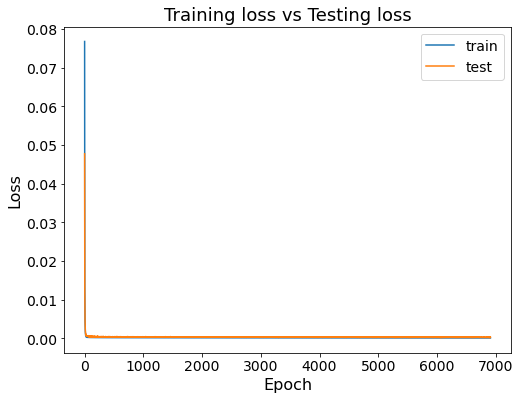

In [40]:
lr = 0.0001
EPOCHS = 8000

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


ws_pararcnn.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
              optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1500)
mc = ModelCheckpoint('saved_model/ws_pararcnn_sc1_4layer_{}h.h5'.format(K), monitor='val_mae', mode='min', verbose=2, save_best_only=True)

history = ws_pararcnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=True,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

In [35]:
# model_load.predict(test_input).shape

### Performance

In [41]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/ws_pararcnn_sc1_4layer_{}h.h5'.format(K))

In [42]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)


In [43]:
# inv_y

In [44]:
# inv_yhat

In [45]:
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 0.053
RMSE = 0.0744
